# California Housing Prices - Training and Testing

**Key notes:**
- Model Selection
- Parameter Tuning
- Performance Testing

In [72]:
import pandas as pd
import numpy as np
from scipy.special import boxcox1p
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import math
import pickle
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

From the previous notebook, the following functions were created. Now, we integrate them together. (The remove_outliers and keep_important_features functions are adjusted.) 

In [2]:
# Missing value inputation
def replace_missing_values_with_median(data):
    data.fillna(data.mean(), inplace=True)
    return data


# Removing outliers
def calculate_bounds(data, col):
    percentile_25 = np.percentile(data[col], 25)
    percentile_75 = np.percentile(data[col], 75)
    iqr = percentile_75 - percentile_25
    lower_bound = percentile_25 - 1.5*iqr
    upper_bound = percentile_75 + 1.5*iqr
    result = {}
    result["column"] = col
    result["lower_bound"] = round(lower_bound, 3)
    result["upper_bound"] = round(upper_bound, 3)
    return result


def remove_outliers(data, selected_attributes):
    bounds_by_column_df = pd.read_csv("bounds_by_column.csv")
    for col in selected_attributes:
        lower_bound = bounds_by_column_df.loc[bounds_by_column_df.column == col, "lower_bound"].values[0]
        upper_bound = bounds_by_column_df.loc[bounds_by_column_df.column == col, "upper_bound"].values[0]
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data


# Adjust skewness
def adjust_skewness(data):
    data["total_rooms"] = data["total_rooms"].apply(lambda x: boxcox1p(x, 0.62))
    data["median_income"] = data["median_income"].apply(lambda x: boxcox1p(x, 0.24))
    data['population'] = data['population'].apply(lambda x: boxcox1p(x, 0.68))
    data["total_bedrooms"] = data["total_bedrooms"].apply(lambda x: boxcox1p(x, 0.68))
    data["households"] = data["households"].apply(lambda x: boxcox1p(x, 0.72))
    return data


# Add new attributes
def add_new_attributes(data):
    data["longitude_over_latitude"] = data["longitude"] / data["latitude"]
    data["total_bedrooms_over_total_rooms"] = data["total_bedrooms"] / data["total_rooms"]
    data["population_over_total_rooms"] = data["population"] / data["total_rooms"]
    data["households_over_total_rooms"] = data["households"] / data["total_rooms"]
    data["population_over_total_bedrooms"] = data["population"] / data["total_bedrooms"]
    data["households_over_total_bedrooms"] = data["households"] / data["total_bedrooms"]
    data["population_over_households"] = data["population"] / data["households"]
    return data


# One hot encoding
def one_hot_encoding(data):
    data["ocean_proximity"] = data["ocean_proximity"].str.lower()
    data = pd.get_dummies(data, columns = ["ocean_proximity"])
    return data


# Standard scaling
def standard_scaling(data):
    # Split into attributes and target 
    X = data.loc[:, ~data.columns.isin(["median_house_value"])]
    y = data.loc[:, data.columns.isin(["median_house_value"])]
    # Define standard scaler
    scaler = StandardScaler()
    # Transform data
    X_new = scaler.fit_transform(X)
    # Convert to dataframe
    X_new = pd.DataFrame(X_new, columns=X.columns)
    return X_new, y


# Feature selction 
def keep_important_features(X):
    with open ("important_feature_list", "rb") as fp:
        important_features = pickle.load(fp)
    print(f"{len(important_features)} features are selected.")
    print(important_features)
    X = X[important_features]
    return X 

In [3]:
def clean_data(X, y):
    # Horizontally concatenate X and y 
    data = pd.concat([X, y], axis=1)
    # Missing value inputation
    data = replace_missing_values_with_median(data)
    # Removing outliers
    selected_attributes = selected_attributes = ["housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]
    data = remove_outliers(data, selected_attributes)
    # Adjust skewness
    data = adjust_skewness(data)
    # Add new attributes
    data = add_new_attributes(data)
    # One hot encoding
    data = one_hot_encoding(data)
    # Standard scaling
    X, y = standard_scaling(data)
    # Feature selction 
    X = keep_important_features(X)
    return X, y

In [4]:
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")

In [5]:
print(X_train.shape)
print(y_train.shape)
X_train.head()

(14448, 9)
(14448, 1)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,INLAND
1,-122.21,37.77,43.0,1017.0,328.0,836.0,277.0,2.2604,NEAR BAY
2,-118.04,33.87,17.0,2358.0,396.0,1387.0,364.0,6.2990,<1H OCEAN
3,-118.28,34.06,17.0,2518.0,1196.0,3051.0,1000.0,1.7199,<1H OCEAN
4,-119.81,36.73,50.0,772.0,194.0,606.0,167.0,2.2206,INLAND


In [7]:
X_train, y_train = clean_data(X_train, y_train)

9 features are important.
['longitude', 'latitude', 'housing_median_age', 'median_income', 'longitude_over_latitude', 'population_over_total_rooms', 'population_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


In [8]:
print(X_train.shape)
print(y_train.shape)
X_train.head()

(12296, 9)
(12296, 1)


,longitude,latitude,housing_median_age,median_income,longitude_over_latitude,population_over_total_rooms,population_over_total_bedrooms,population_over_households,ocean_proximity_inland
0,-0.085055,0.474493,1.802160,-1.189034,0.656749,3.134813,4.127777,2.675156,1.436943
1,-1.290886,0.954125,1.068269,-0.929797,0.828809,0.890962,-0.198545,0.165600,-0.695922
2,0.786930,-0.844495,-1.051862,1.614041,-0.839319,0.121927,0.782017,0.931160,-0.695922
3,-0.095021,0.474493,1.639073,-0.964886,0.653108,0.672946,0.424717,0.940066,1.436943
4,-0.817523,1.378415,-1.051862,1.089898,1.507510,-0.371538,0.095545,0.218827,1.436943


## Model Selection

In [9]:
def evaluate_performance_of_model(X_train, y_train, model_name):
    result = {}
    result["Model"] = model_name
    
    if model_name == "Linear":
        model = LinearRegression()
    if model_name == "Ridge":
        model = Ridge(random_state=0)
    if model_name == "Lasso":
        model = Lasso(random_state=0)     
    if model_name == "SVR":
        model = SVR()
    if model_name == "Decision Tree":
        model = DecisionTreeRegressor(random_state=0)
    if model_name == "Random Forest":
        model = RandomForestRegressor(random_state=0)
    if model_name == "Gradient Boosting":
        model = GradientBoostingRegressor(random_state=0)

    print(model_name)
    print("Parameters currently in use:")
    pprint(model.get_params())
    print()

    # Get the R2 value
    r2_scores = cross_val_score(model, X_train, y_train.values.ravel(), cv=5, scoring="r2")
    r2 = np.sqrt(r2_scores).mean() 
    result["R2"] = round(r2, 3)

    # Get the RMSE value 
    rmse_scores = cross_val_score(model, X_train, y_train.values.ravel(), cv=5, scoring="neg_mean_squared_error")
    rmse = np.sqrt(-rmse_scores).mean()
    result["RMSE"] = round(rmse, 3)
    
    return result 

In [10]:
def evaluate_performance(X_train, y_train):
    results = []
    for model_name in ["Linear", "Ridge", "Lasso", "SVR", "Decision Tree", "Random Forest", "Gradient Boosting"]:
        result = evaluate_performance_of_model(X_train, y_train, model_name)
        results.append(result)
    results_df = pd.DataFrame(results)
    return results_df

In [11]:
results_df = evaluate_performance(X_train, y_train)
results_df

Linear
Parameters currently in use:
{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': False,
 'positive': False}

Ridge
Parameters currently in use:
{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': 0,
 'solver': 'auto',
 'tol': 0.001}

Lasso
Parameters currently in use:
{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': 0,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}



/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18527324454705.98, tolerance: 11194963989.019884
  model = cd_fast.enet_coordinate_descent(
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20568933919423.836, tolerance: 11167389282.05485
  model = cd_fast.enet_coordinate_descent(
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21171246252217.586, tolerance: 11255808814.147102
  model = cd_fast.enet_coordinate_descent(
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/li

SVR
Parameters currently in use:
{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}



<ipython-input-9-0ffa8c40da2a>:27: RuntimeWarning: invalid value encountered in sqrt
  r2 = np.sqrt(r2_scores).mean()


Decision Tree
Parameters currently in use:
{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 0,
 'splitter': 'best'}

Random Forest
Parameters currently in use:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

Gradient Boosting
Parameters currently in use:
{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'ma

,Model,R2,RMSE
0,Linear,0.757,69884.970
1,Ridge,0.757,69882.662
2,Lasso,0.757,69881.410
3,SVR,NaN,108933.496
4,Decision Tree,0.765,68824.449
5,Random Forest,0.886,49556.332
6,Gradient Boosting,0.874,52065.314


In [12]:
def plot_scores_by_model(results_df):
    fig,axes = plt.subplots(2, 1, figsize=(12,8), dpi=300)
    palette = sns.color_palette("Set3", results_df.shape[0])
    sns.barplot(x="Model", y="R2", data=results_df, ax=axes[0], alpha=0.8, palette=palette)
    sns.barplot(x="Model", y="RMSE", data=results_df, ax=axes[1], alpha=0.8, palette=palette)
    for ax in axes:
        for p in ax.patches:
            ax.annotate(format(p.get_height(), ".3f"), 
                        (p.get_x()+p.get_width()/2, p.get_y()+p.get_height()), 
                        ha="center", va="top", xytext=(0, 10), textcoords="offset points")
    plt.show()

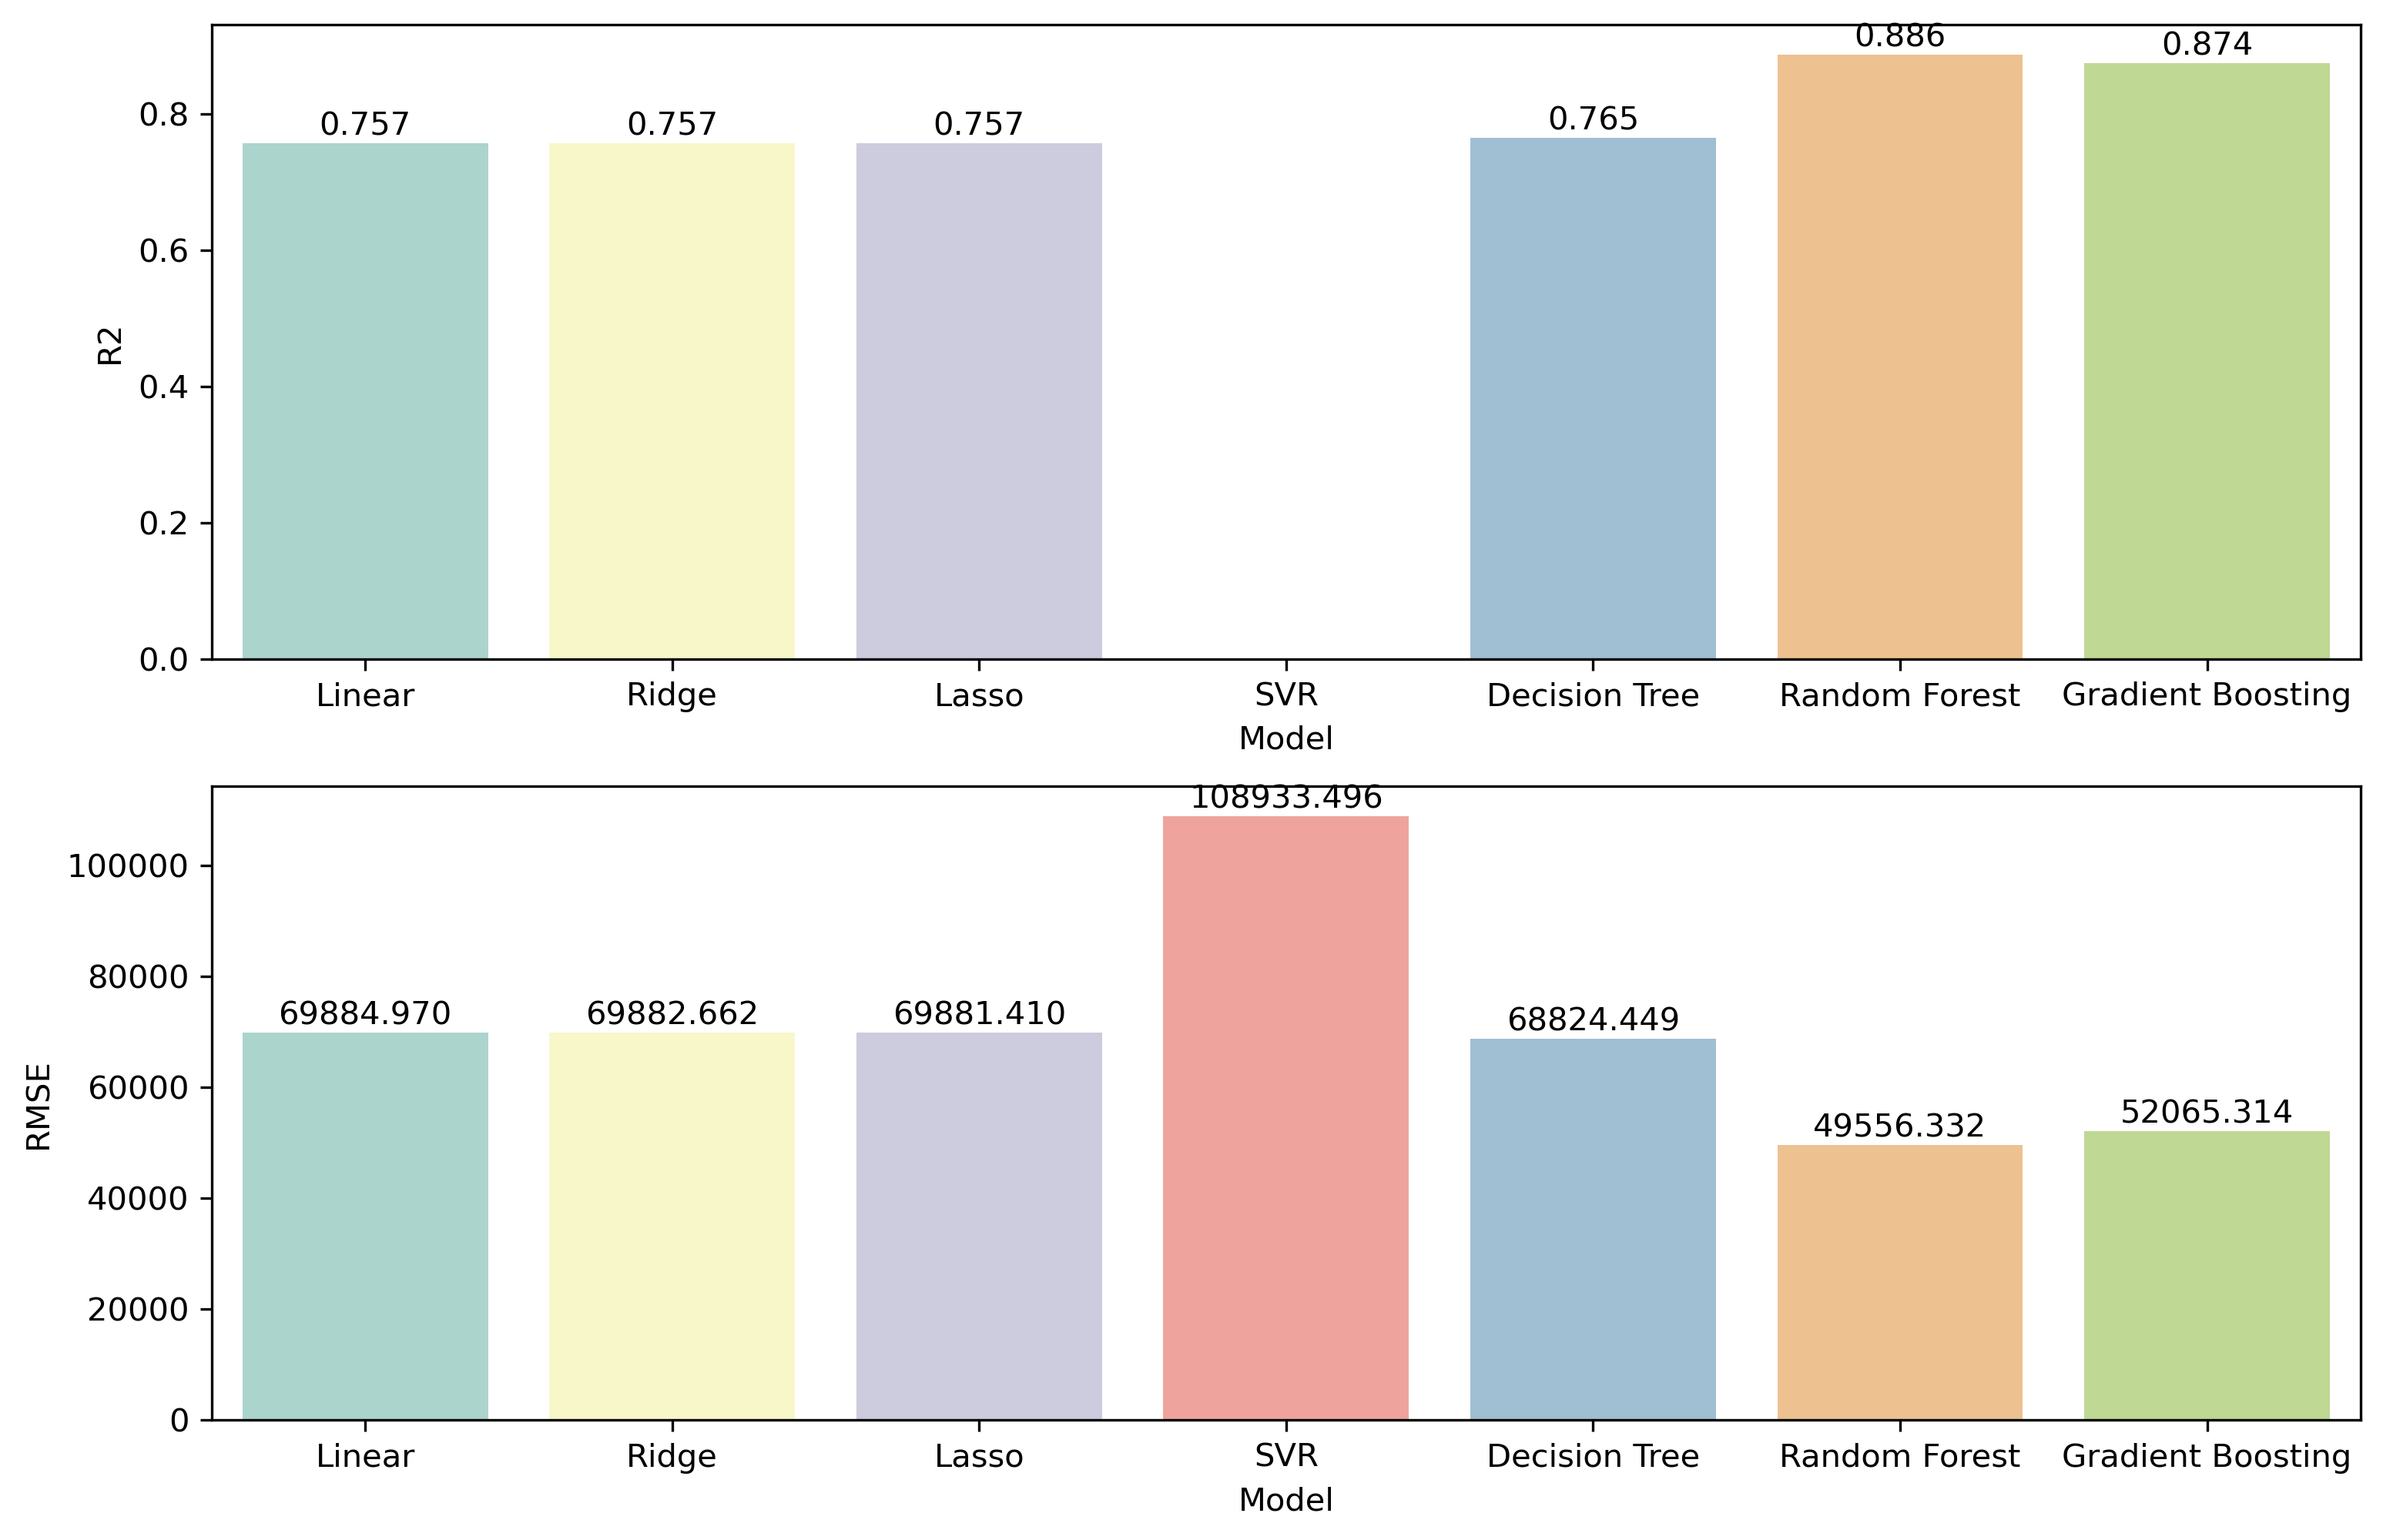

In [13]:
plot_scores_by_model(results_df)

It turns out that **Random Forest** and **Gradient Boosting** have relatively higher R2 values and lower RMSE values. Hence, only the parameters of these two models are tuned. Since the parameter tuning is a time consuming process, only the parameter tuning of **Random Forest** is included in this notebook, and that of **Gradient Boosting** is skipped.

## Parameter Tuning

In [14]:
def get_mean_score(X_train, y_train, model_name, param_name, param_range, scoring):
    
    # Define the model
    if model_name == "Random Forest":
        model = RandomForestRegressor(random_state=0)
    if model_name == "Gradient Boosting":
        model = GradientBoostingRegressor(random_state=0)  
    
    # Calculate accuracy on training and test set using the
    # gamma parameter with 5-fold cross validation
    train_scores, valid_scores = validation_curve(model, X_train, y_train.values.ravel(),
                                                   param_name=param_name,
                                                   param_range=param_range,
                                                   cv=5, scoring=scoring, n_jobs=-1)
    if scoring == "neg_mean_squared_error":
        train_scores = -train_scores
        valid_scores = -valid_scores
    
    # Calculating mean and standard deviation of training score
    mean_train_score = np.mean(train_scores, axis=1)
    std_train_score = np.std(train_scores, axis=1)

    # Calculating mean and standard deviation of testing score
    mean_valid_score = np.mean(valid_scores, axis=1)
    std_valid_score = np.std(valid_scores, axis=1)
    
#     print(f"Train {scoring} score: mean: {mean_train_score}, std: {std_train_score} \n")
#     print(f"Valid {scoring} score: mean: {mean_valid_score}, std: {std_valid_score} \n")
    
    return mean_train_score, mean_valid_score

In [15]:
def get_train_valiation_score(X_train, y_train, model_name, param_name, param_range): 
    
    print("--- Tuning parameters ...")
    print(f"{param_name}: {[i for i in param_range]}")

    mean_train_score_r2, mean_valid_score_r2 = get_mean_score(X_train, y_train, model_name, param_name, param_range, scoring="r2")
    
    mean_train_score_rmse, mean_valid_score_rmse = get_mean_score(X_train, y_train, model_name, param_name, param_range, scoring="neg_mean_squared_error")
    
    frame = {"parameter": pd.Series(param_range),
             "mean_train_score_r2": pd.Series(mean_train_score_r2), 
             "mean_valid_score_r2": pd.Series(mean_valid_score_r2),
             "mean_train_score_rmse": pd.Series(mean_train_score_rmse), 
             "mean_valid_score_rmse": pd.Series(mean_valid_score_rmse)}
    df = pd.DataFrame(frame)
    print(df)
    
    df_new = pd.melt(df, 
                     id_vars="parameter", value_vars=list(df.columns[1:]), 
                     var_name="score type", value_name="value")

    df_new["dataset"] = df_new["score type"].apply(lambda x: x.split("_")[1])
    df_new["scoring"] = df_new["score type"].apply(lambda x: x.split("_")[-1])
    df_new.drop(columns=["score type"], inplace=True)
    df_new = df_new[["parameter", "dataset", "scoring", "value"]]

    return df_new

In [16]:
def plot_validation_curve(results_df, param_name): 
    
    fig,axes = plt.subplots(2, 1, figsize=(8,5), dpi=300)
    
    # First subplot - R2
    sns.lineplot(x="parameter", y="value", hue="dataset",
                 data=results_df[results_df["scoring"] == "r2"], ax=axes[0])
    axes[0].set_ylim(0, 1)
    axes[0].set_xlabel(f"{param_name}")
    axes[0].set_ylabel("R2")
    axes[0].legend(loc="best")
    
    # Second subplot - RMSE
    sns.lineplot(x="parameter", y="value", hue="dataset",
                 data=results_df[results_df["scoring"] == "rmse"], ax=axes[1])
    axes[1].set_xlabel(f"{param_name}")
    axes[1].set_ylabel("RMSE")
    axes[1].legend(loc="best")
    
    plt.tight_layout()
    plt.show()

### Random Forest

Before grid searching, I first investigate how each parameter imppact the performance on training and validation dataset to narrow down the range of grid search.

**max_depth**

--- Tuning parameters ...
max_depth: [1, 2, 3, 4, 5, 6, 7, 8, 9]
   parameter  mean_train_score_r2  mean_valid_score_r2  mean_train_score_rmse  \
0          1             0.293157             0.286925           8.099456e+09   
1          2             0.458526             0.451717           6.204619e+09   
2          3             0.566415             0.555342           4.968362e+09   
3          4             0.629698             0.615123           4.243195e+09   
4          5             0.685036             0.660879           3.609040e+09   
5          6             0.737586             0.702152           3.006822e+09   
6          7             0.779686             0.727541           2.524420e+09   
7          8             0.815843             0.744895           2.110088e+09   
8          9             0.848102             0.756776           1.740448e+09   

   mean_valid_score_rmse  
0           8.168368e+09  
1           6.280861e+09  
2           5.092911e+09  
3           4.40

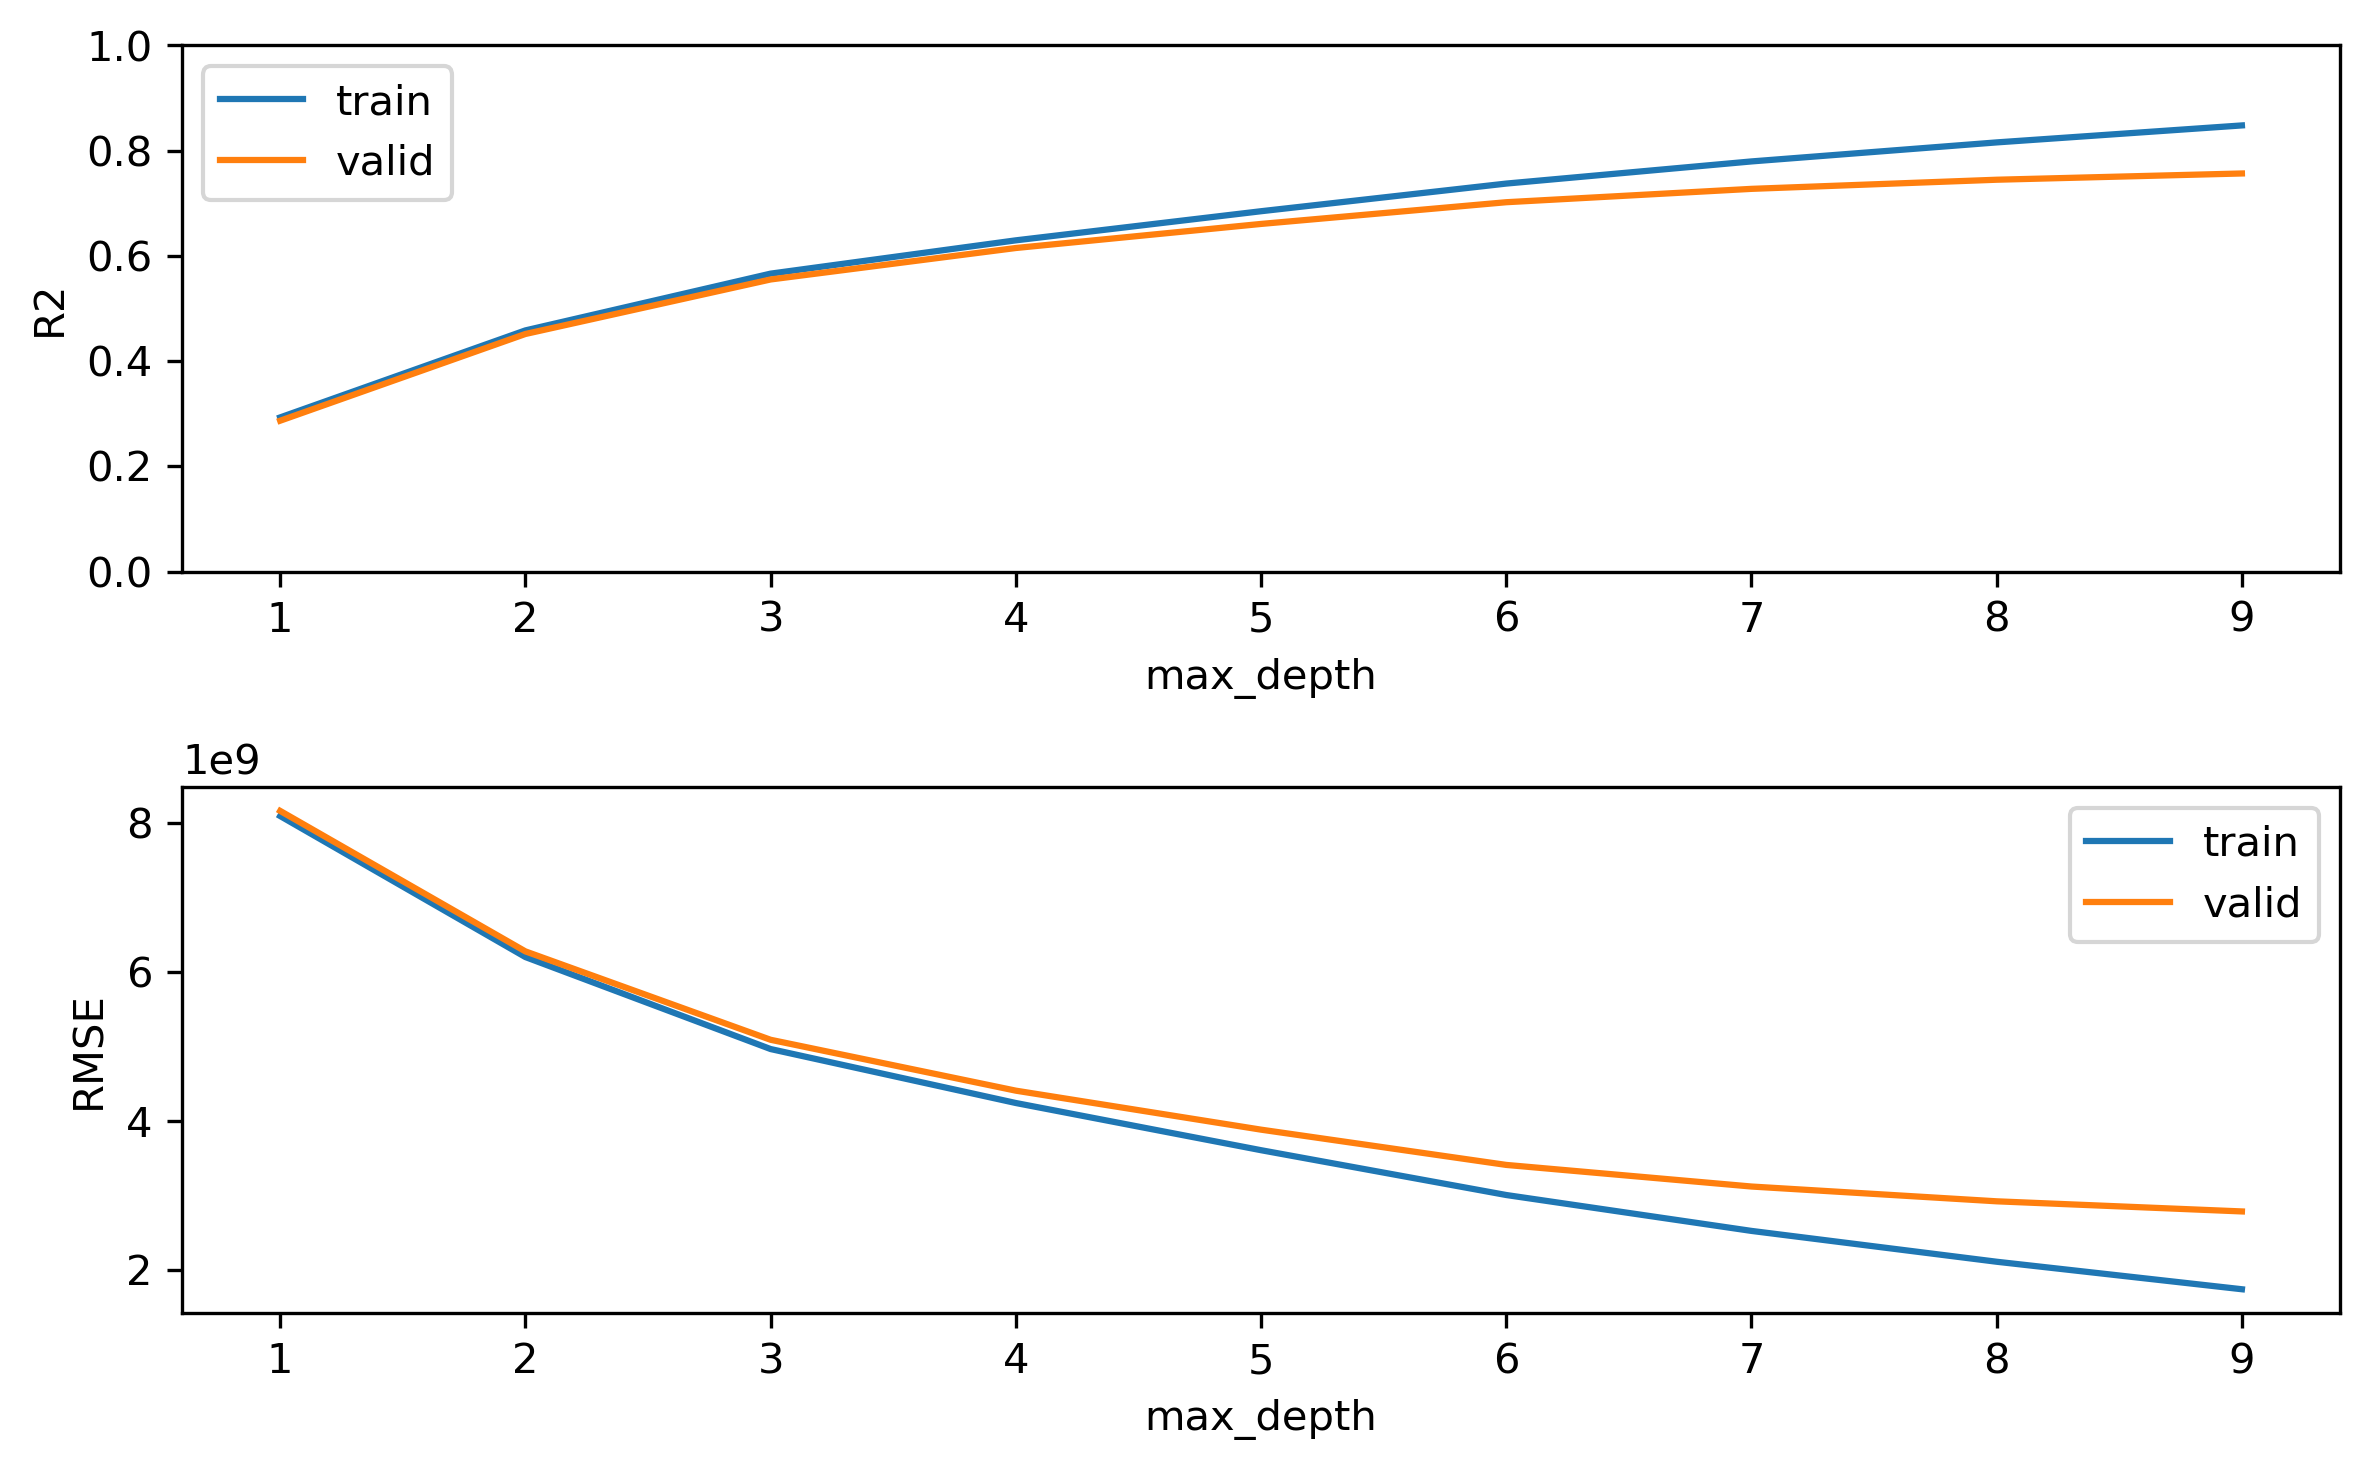

In [20]:
model_name = "Random Forest"
param_name = "max_depth"
param_range = range(1,10,1)

results_df = get_train_valiation_score(X_train, y_train, model_name, param_name, param_range)
plot_validation_curve(results_df, param_name="max_depth")

**max_features**

--- Tuning parameters ...
max_features: [1, 2, 3, 4, 5, 6, 7, 8, 9]
   parameter  mean_train_score_r2  mean_valid_score_r2  mean_train_score_rmse  \
0          1             0.971168             0.796319           3.303506e+08   
1          2             0.972089             0.804237           3.198041e+08   
2          3             0.972138             0.804098           3.192472e+08   
3          4             0.971727             0.801397           3.239690e+08   
4          5             0.971371             0.796883           3.280477e+08   
5          6             0.970999             0.794635           3.323129e+08   
6          7             0.970582             0.792363           3.370953e+08   
7          8             0.970122             0.789564           3.423600e+08   
8          9             0.969613             0.785533           3.481924e+08   

   mean_valid_score_rmse  
0           2.333446e+09  
1           2.242360e+09  
2           2.243688e+09  
3           2

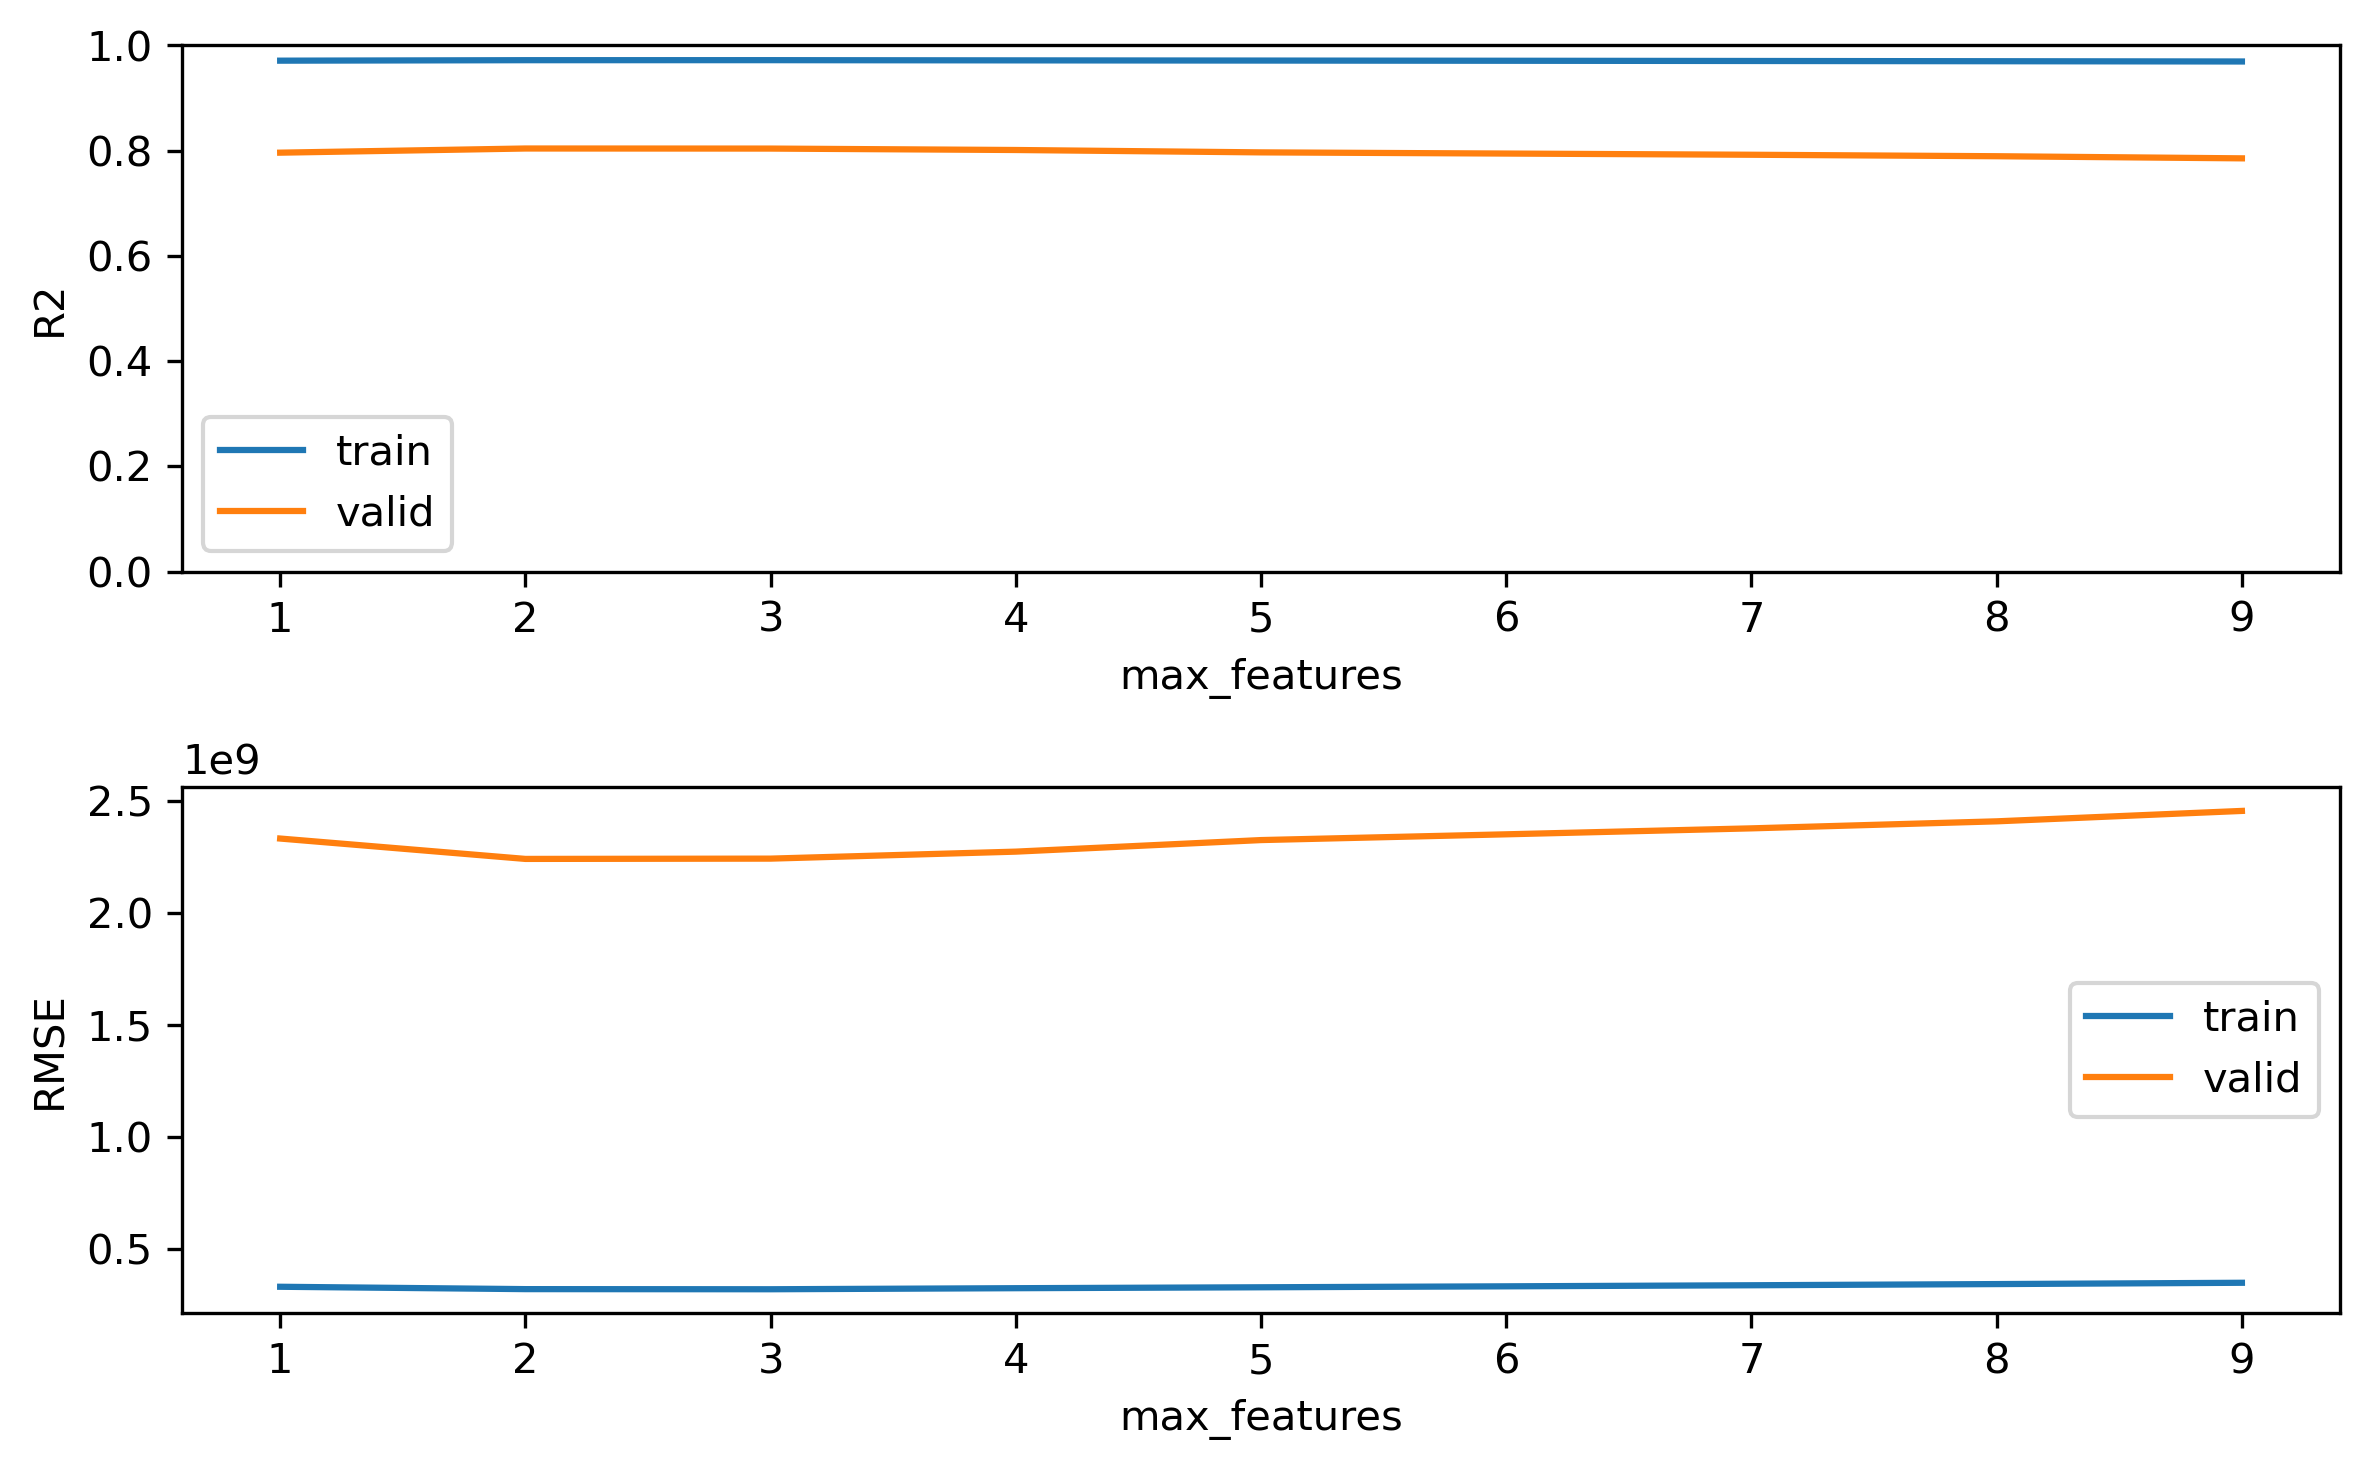

In [21]:
model_name = "Random Forest"
param_name = "max_features"
param_range = range(1,10,1)

results_df = get_train_valiation_score(X_train, y_train, model_name, param_name, param_range)
plot_validation_curve(results_df, param_name="max_features")

**min_samples_split**

--- Tuning parameters ...
min_samples_split: [2, 102, 202, 302, 402, 502, 602, 702, 802, 902, 1002]
    parameter  mean_train_score_r2  mean_valid_score_r2  \
0           2             0.969613             0.785533   
1         102             0.792669             0.743375   
2         202             0.741651             0.710296   
3         302             0.706121             0.682449   
4         402             0.670250             0.652326   
5         502             0.646170             0.630586   
6         602             0.628860             0.614948   
7         702             0.609209             0.596945   
8         802             0.592444             0.581668   
9         902             0.581569             0.571302   
10       1002             0.574507             0.564751   

    mean_train_score_rmse  mean_valid_score_rmse  
0            3.481924e+08           2.456893e+09  
1            2.375773e+09           2.939973e+09  
2            2.960358e+09           3.

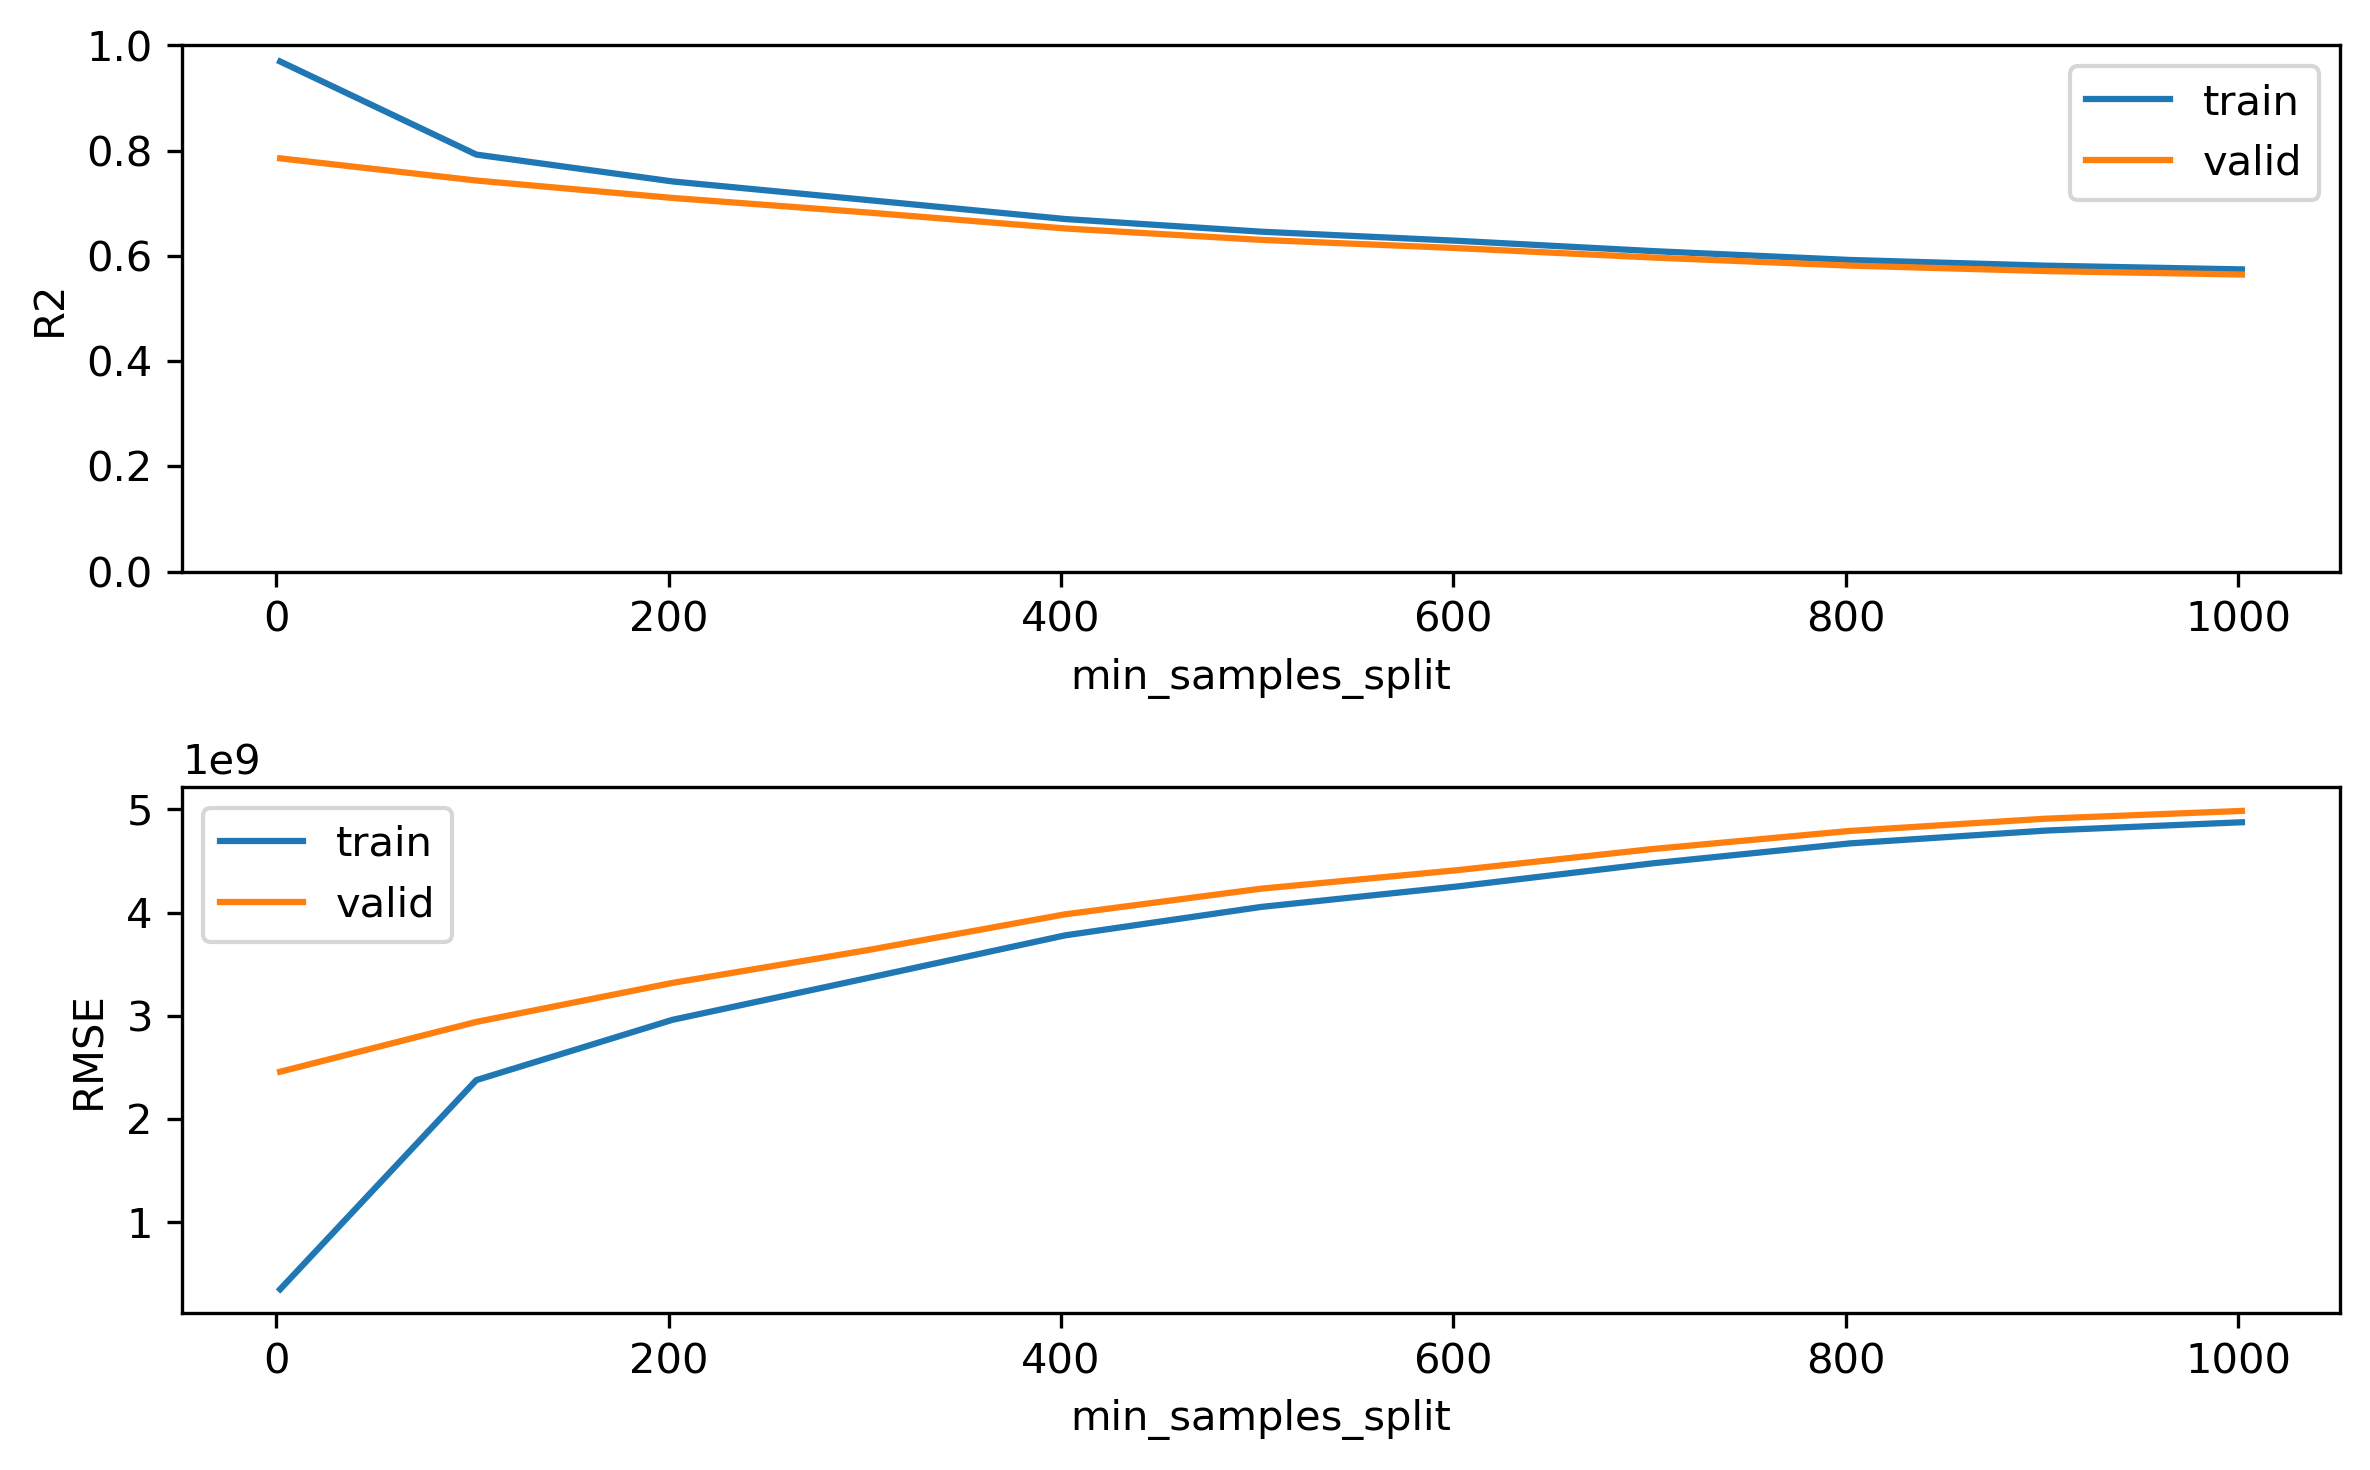

In [32]:
model_name = "Random Forest"
param_name = "min_samples_split"
param_range = range(2,1102,100)

results_df = get_train_valiation_score(X_train, y_train, model_name, param_name, param_range)
plot_validation_curve(results_df, param_name="min_samples_split")

**min_samples_leaf**

--- Tuning parameters ...
min_samples_leaf: [1, 101, 201, 301, 401, 501, 601, 701, 801, 901, 1001]
    parameter  mean_train_score_r2  mean_valid_score_r2  \
0           1             0.969613             0.785533   
1         101             0.700712             0.680501   
2         201             0.633815             0.620684   
3         301             0.604565             0.593337   
4         401             0.573510             0.564101   
5         501             0.554165             0.545241   
6         601             0.544147             0.535965   
7         701             0.531865             0.524937   
8         801             0.513642             0.507569   
9         901             0.501855             0.496234   
10       1001             0.487206             0.480287   

    mean_train_score_rmse  mean_valid_score_rmse  
0            3.481924e+08           2.456893e+09  
1            3.429483e+09           3.660089e+09  
2            4.196022e+09           4.3

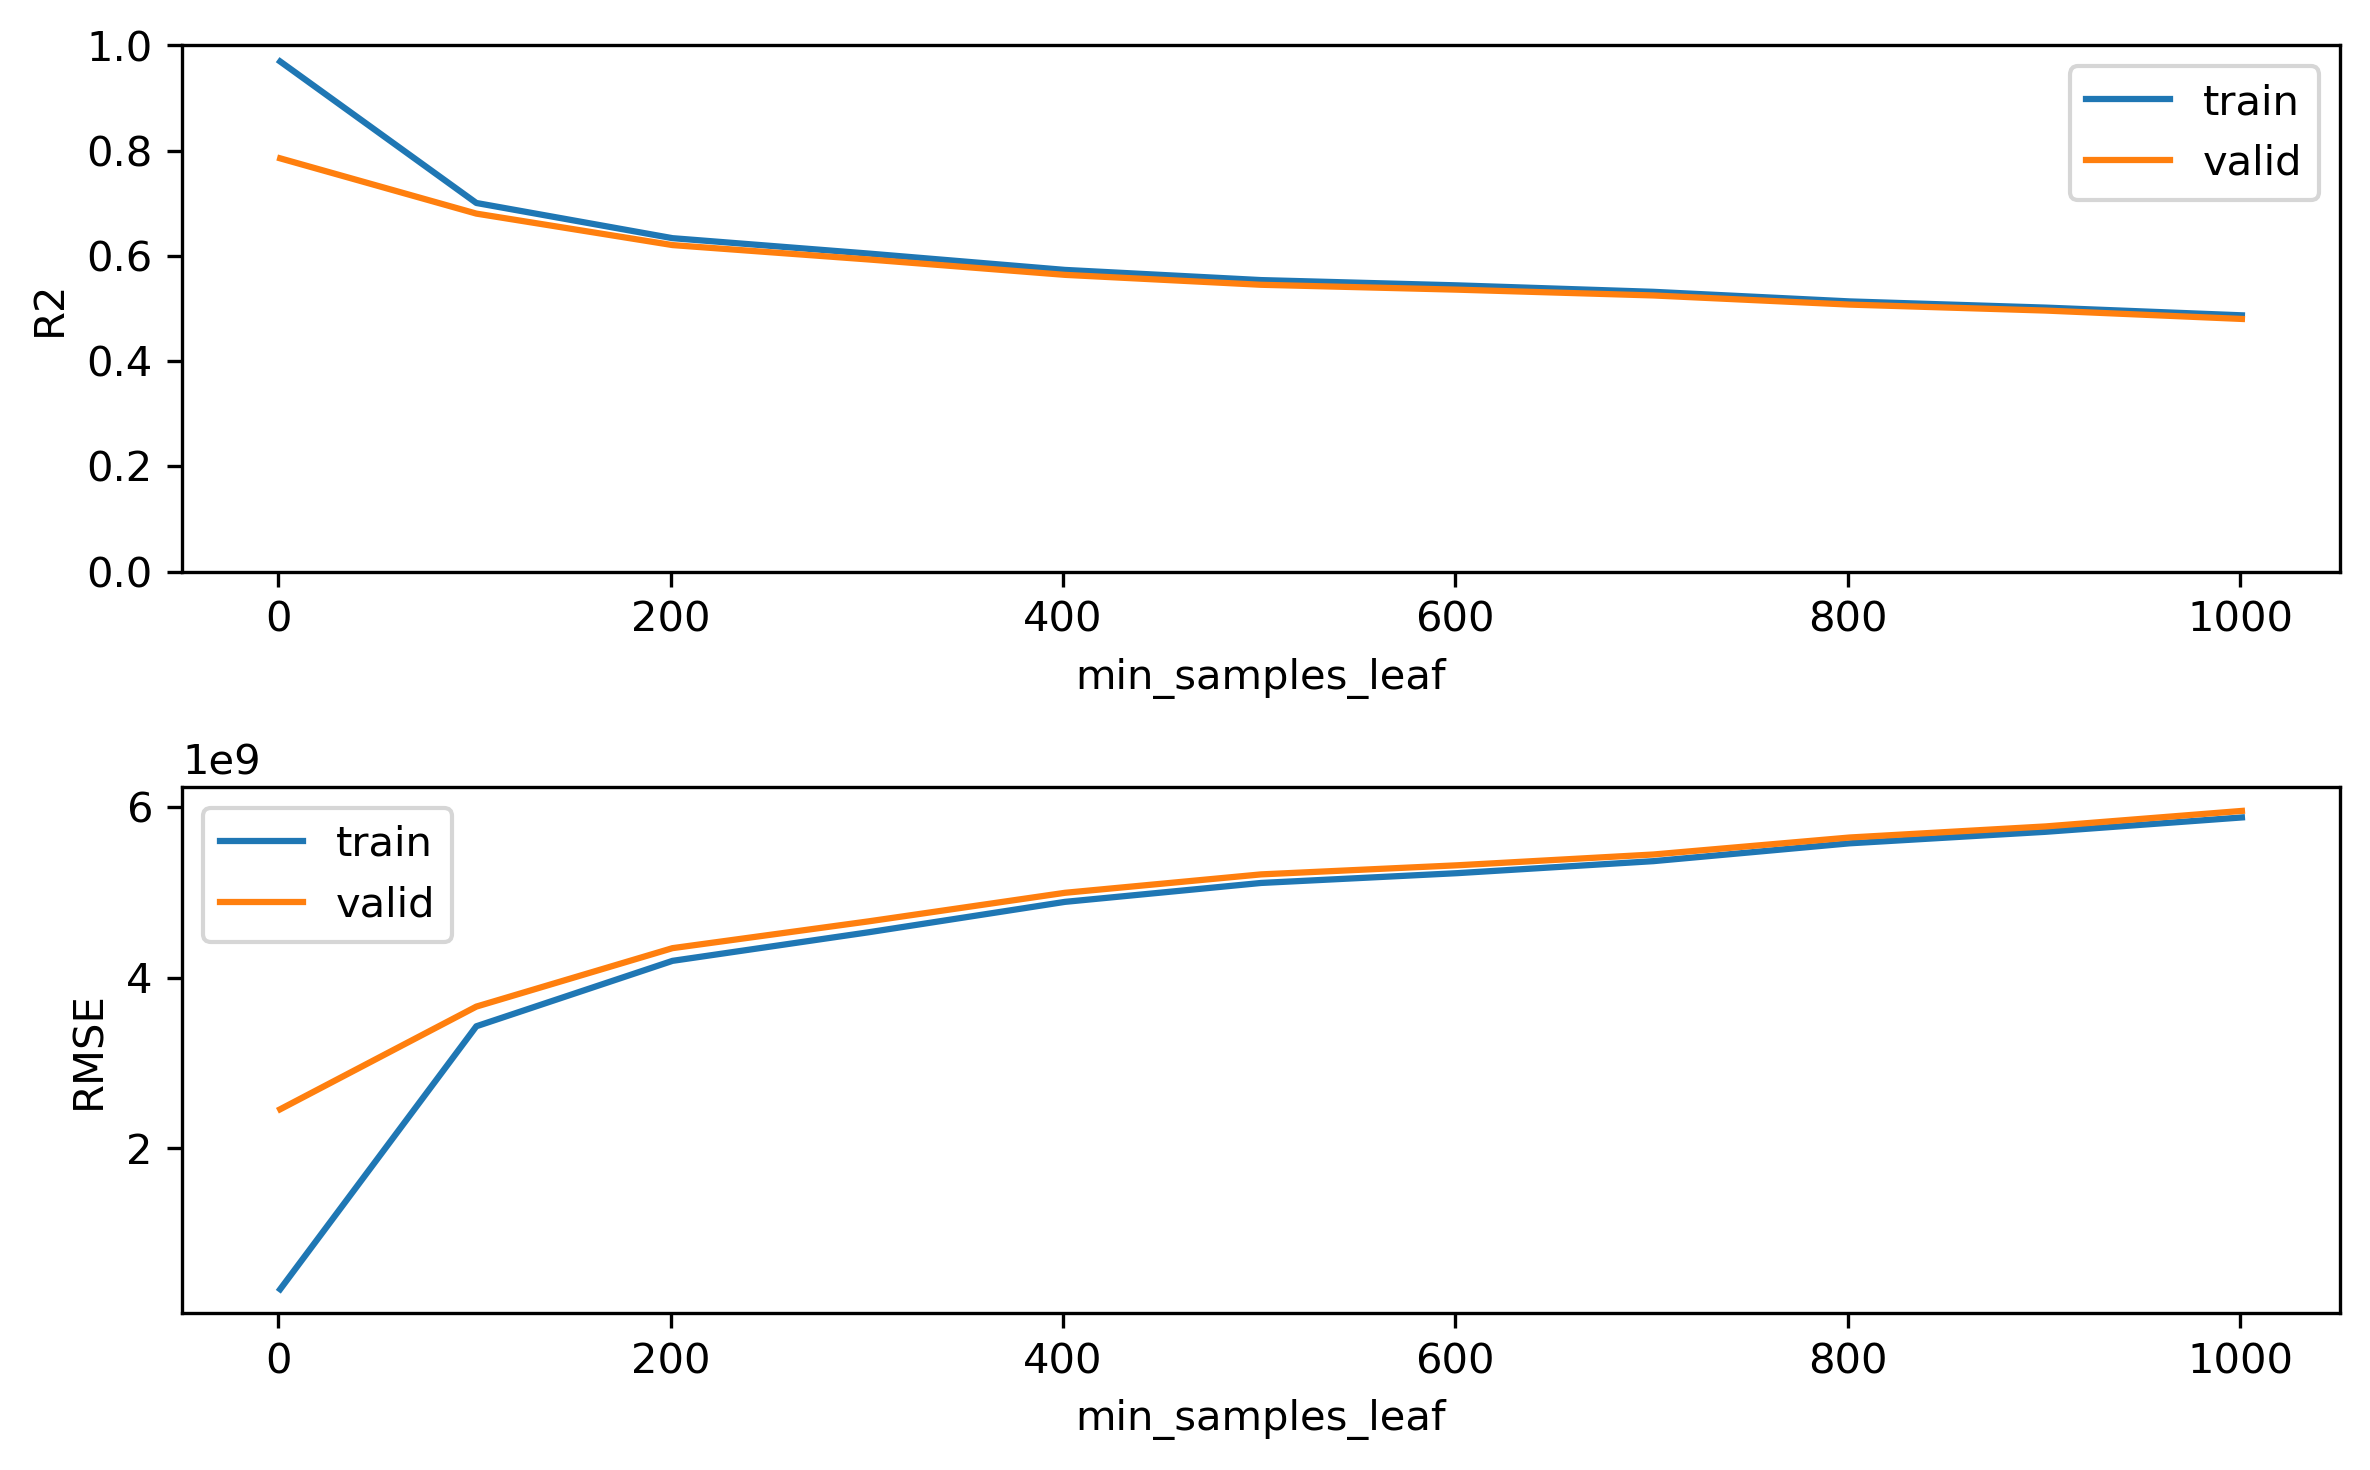

In [31]:
model_name = "Random Forest"
param_name = "min_samples_leaf"
param_range = range(1,1101,200)

results_df = get_train_valiation_score(X_train, y_train, model_name, param_name, param_range)
plot_validation_curve(results_df, param_name="min_samples_leaf")

**n_estimators**

--- Tuning parameters ...
n_estimators: [100, 300, 500, 700, 900]
   parameter  mean_train_score_r2  mean_valid_score_r2  mean_train_score_rmse  \
0        100             0.969613             0.785533           3.481924e+08   
1        300             0.970705             0.788004           3.356643e+08   
2        500             0.970992             0.788513           3.323722e+08   
3        700             0.970997             0.788492           3.323262e+08   
4        900             0.971050             0.788679           3.317122e+08   

   mean_valid_score_rmse  
0           2.456893e+09  
1           2.428636e+09  
2           2.422818e+09  
3           2.422994e+09  
4           2.420934e+09  


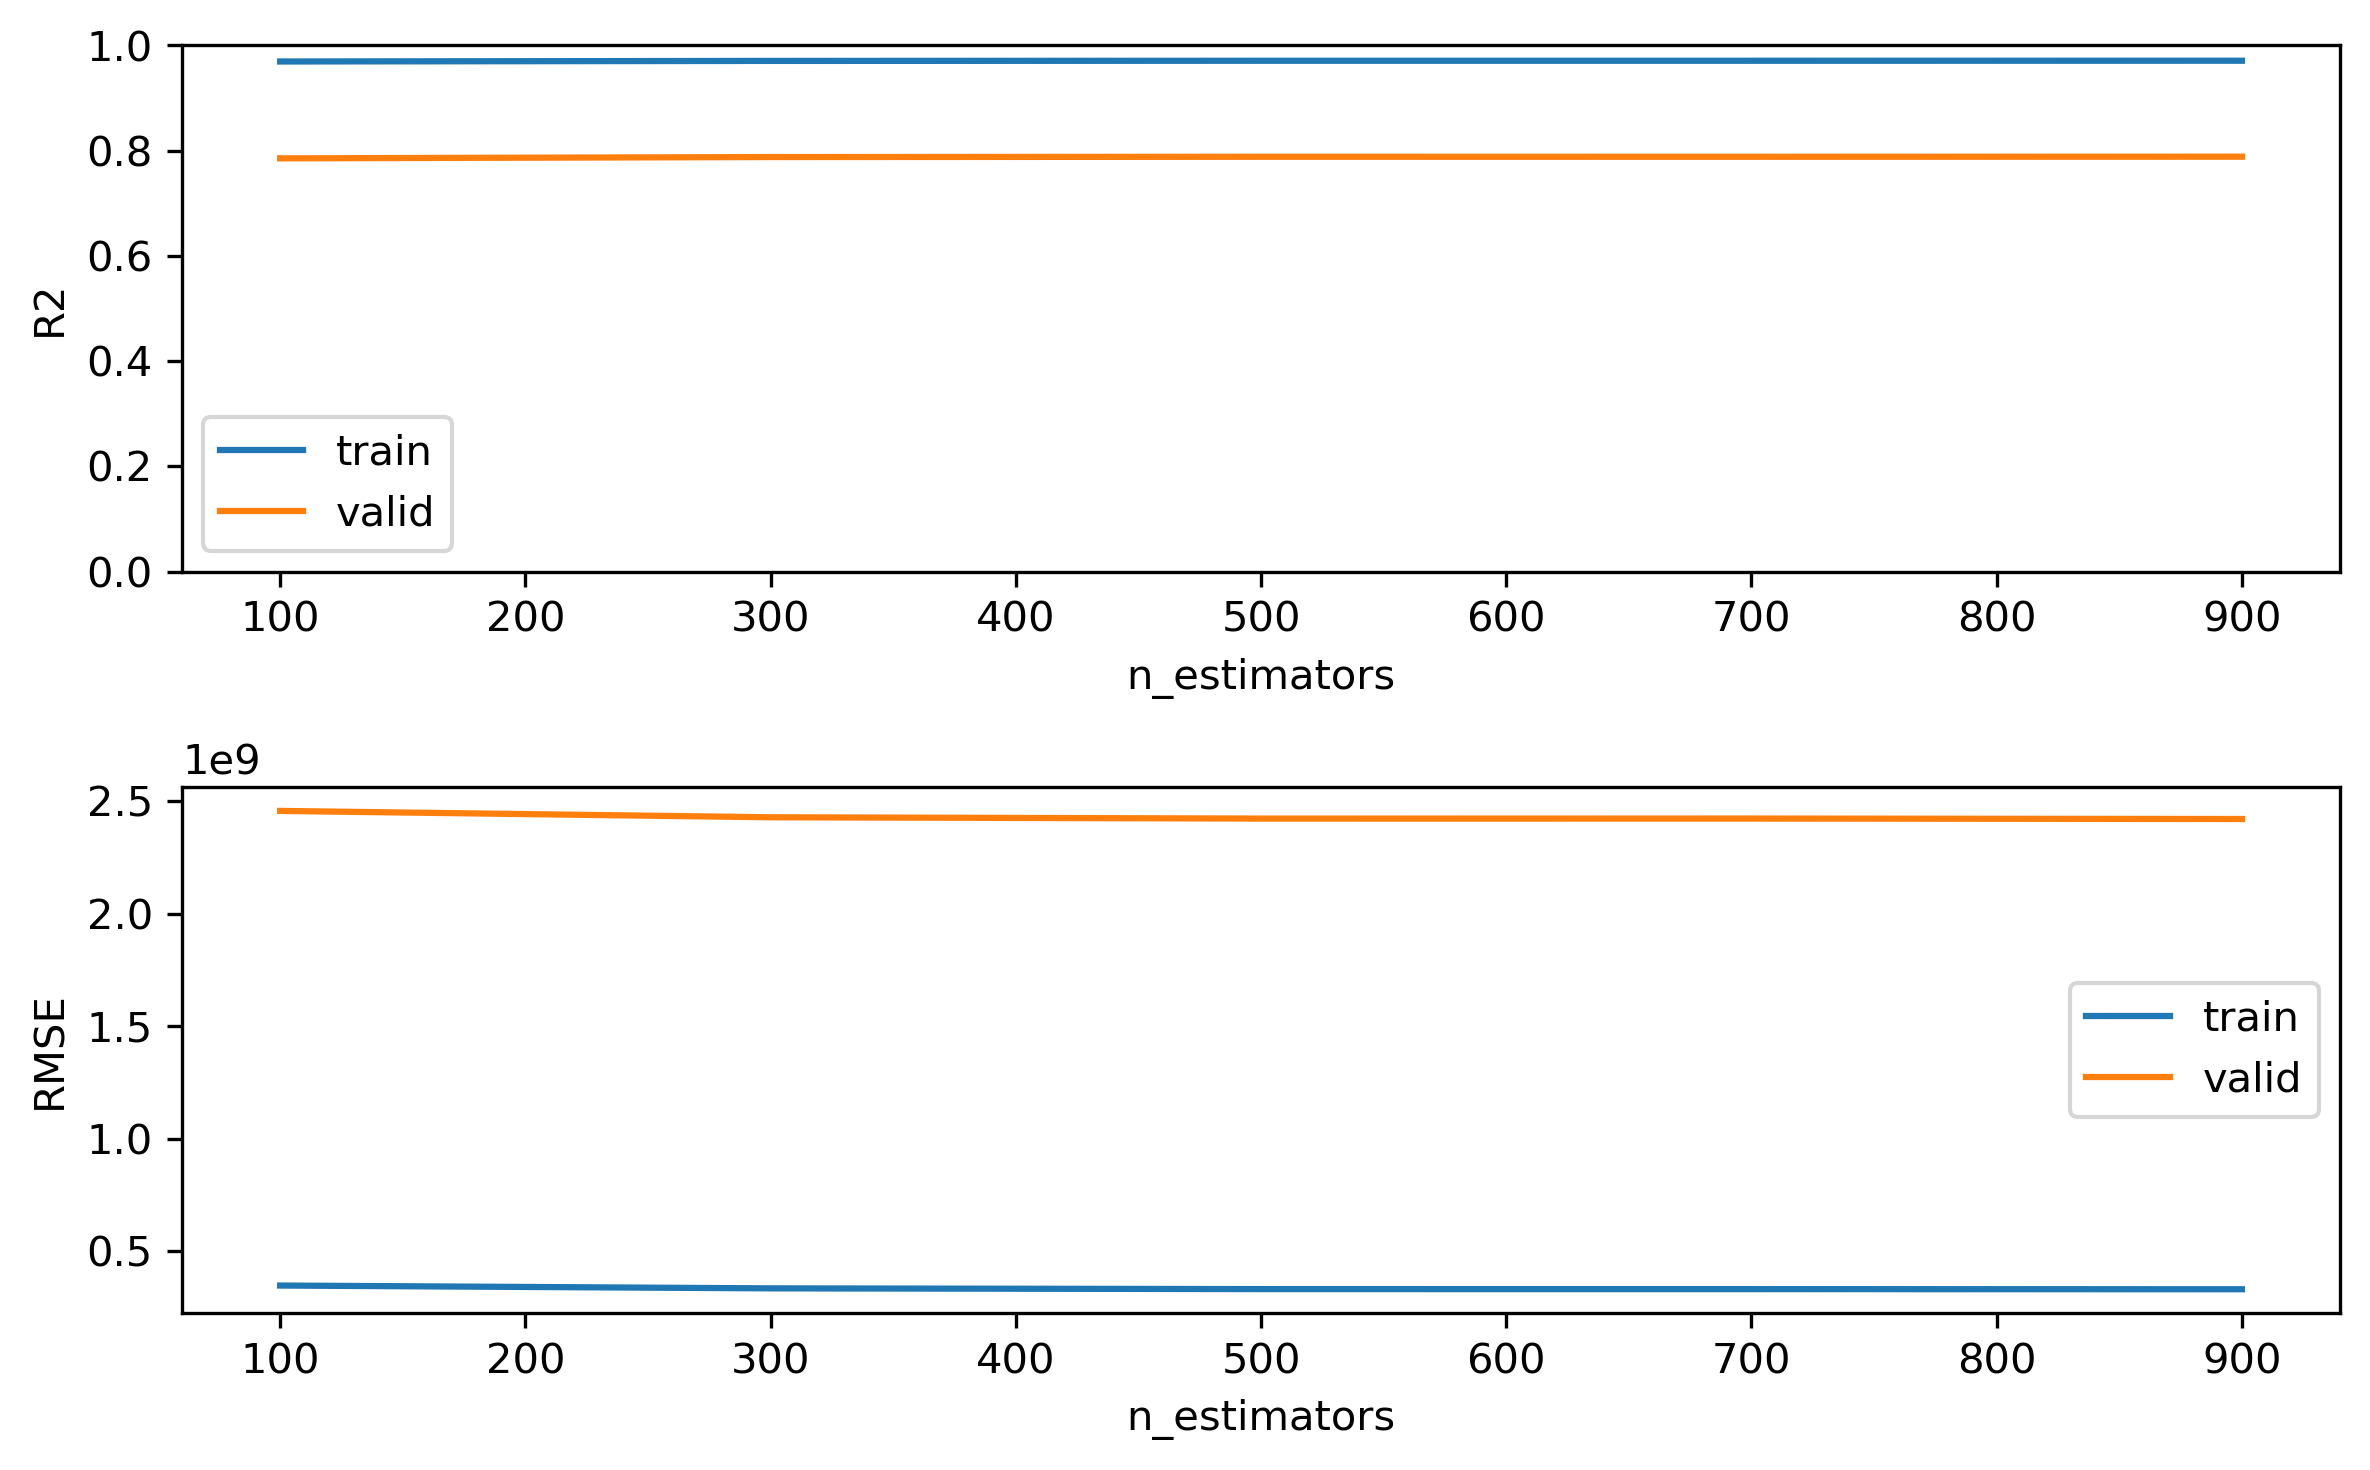

In [37]:
model_name = "Random Forest"
param_name = "n_estimators"
param_range = range(100,1100,100)

results_df = get_train_valiation_score(X_train, y_train, model_name, param_name, param_range)
plot_validation_curve(results_df, param_name="n_estimators")

**Grid Search**

In [54]:
def define_parameter_grid():

    # Maximum number of levels in tree
    max_depth = list(range(4,7,1))
    
    # Number of features to consider at every split
    max_features = ["auto", "sqrt", "log2"]

    # Minimum number of samples required to split a node
    min_samples_split = list(range(100,400,100))

    # Minimum number of samples required at each leaf node
    min_samples_leaf = list(range(100,400,100))
    
    # Number of trees in random forest
    n_estimators = [100, 500, 1000]

    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the random grid
    param_grid = {"max_depth": max_depth,
                  "max_features": max_features,
                  "min_samples_split": min_samples_split,
                  "min_samples_leaf": min_samples_leaf,
                  "n_estimators": n_estimators,
                  "bootstrap": bootstrap}
    
    print("Best parameters:")
    pprint(param_grid)
    
    return param_grid

In [55]:
param_grid = define_parameter_grid()

{'bootstrap': [True, False],
 'max_depth': [4, 5, 6],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [100, 200, 300],
 'min_samples_split': [100, 200, 300],
 'n_estimators': [100, 500, 1000]}


In [56]:
def rf_tune_parameter(X_train, y_train):
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestRegressor(random_state=0)
    
    param_grid = define_parameter_grid()

    # Random search of parameters, using 5-fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                                   n_iter=100, cv=5, verbose=2, random_state=0, n_jobs=-1)

    # Fit the random search model
    rf_random.fit(X_train, y_train.values.ravel())
    
    # Get best parameters 
    best_parameters = rf_random.best_params_
    print(f"Best parameters:")
    print(best_parameters)
    
    return best_parameters

In [57]:
best_parameters = rf_tune_parameter(X_train, y_train)
best_parameters
# {'n_estimators': 1000,
#  'min_samples_split': 100,
#  'min_samples_leaf': 100,
#  'max_features': 'sqrt',
#  'max_depth': 6,
#  'bootstrap': False}

{'bootstrap': [True, False],
 'max_depth': [4, 5, 6],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [100, 200, 300],
 'min_samples_split': [100, 200, 300],
 'n_estimators': [100, 500, 1000]}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


## Performance Testing

In [59]:
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

In [60]:
print(X_test.shape)
print(y_test.shape)
X_test.head()

(6192, 9)
(6192, 1)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-117.05,32.58,22.0,2101.0,399.0,1551.0,371.0,4.1518,NEAR OCEAN
1,-117.97,33.92,32.0,2620.0,398.0,1296.0,429.0,5.7796,<1H OCEAN
2,-121.84,38.65,29.0,3167.0,548.0,1554.0,534.0,4.3487,INLAND
3,-115.60,33.20,37.0,709.0,187.0,390.0,142.0,2.4511,INLAND
4,-122.43,37.79,25.0,1637.0,394.0,649.0,379.0,5.0049,NEAR BAY


In [61]:
X_test, y_test = clean_data(X_test, y_test)

9 features are important.
['longitude', 'latitude', 'housing_median_age', 'median_income', 'longitude_over_latitude', 'population_over_total_rooms', 'population_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


In [62]:
print(X_test.shape)
print(y_test.shape)
X_test.head()

(5228, 9)
(5228, 1)


,longitude,latitude,housing_median_age,median_income,longitude_over_latitude,population_over_total_rooms,population_over_total_bedrooms,population_over_households,ocean_proximity_inland
0,1.278373,-1.439287,-0.645151,0.443344,-1.557116,0.717782,1.171848,1.285215,-0.699613
1,0.818169,-0.817237,0.167682,1.348622,-0.785448,-0.295017,0.544534,0.065196,-0.699613
2,-1.117692,1.378507,-0.076168,0.563518,1.402376,-0.274930,0.098346,-0.097745,1.429361
3,2.003696,-1.151473,0.574098,-0.775067,-0.812593,-0.314664,-0.723646,-0.013821,1.429361
4,-1.412823,0.979281,-0.401301,0.941185,0.815234,-0.855763,-1.273215,-1.449547,-0.699613


In [112]:
def plot_true_predicted(y, y_pred):
    fig = plt.figure(figsize=(8, 6), dpi=300)
    ax = fig.add_subplot(111)
    ax.set_xlabel("True value")
    ax.set_ylabel("Predicted value")
    ax.scatter(y, y_pred, alpha=0.5)
    plt.show()

In [92]:
def evaluate_performance(model, X, y, dataset):
    y_pred = model.predict(X)
    rmse = round(math.sqrt(mean_squared_error(y, y_pred)), 3)
    print(f"{dataset} RMSE: {rmse}")
    plot_true_predicted(y, y_pred)
    return rmse

In [93]:
def evaluate_base_model(X_train, y_train, X_test, y_test):
    rf = RandomForestRegressor(random_state=0)
    rf.fit(X_train, y_train.values.ravel())
    print("Pure Random Forest")
    evaluate_performance(rf, X_train, y_train, "train")
    evaluate_performance(rf, X_test, y_test, "test")

In [101]:
def evaluate_tuned_model(X_train, y_train, X_test, y_test):
    # {'n_estimators': 1000,
    #  'min_samples_split': 100,
    #  'min_samples_leaf': 100,
    #  'max_features': 'sqrt',
    #  'max_depth': 6,
    #  'bootstrap': False}
    rf = RandomForestRegressor(random_state=0, n_estimators=1000, 
                               min_samples_split=100, min_samples_leaf=100,
                               max_features="sqrt", max_depth=6, bootstrap=False)
    rf.fit(X_train, y_train.values.ravel())
    print("Tuned Random Forest")
    evaluate_performance(rf, X_train, y_train, "train")
    evaluate_performance(rf, X_test, y_test, "test")

Pure Random Forest
train RMSE: 18452.116


NameError: name 'x' is not defined

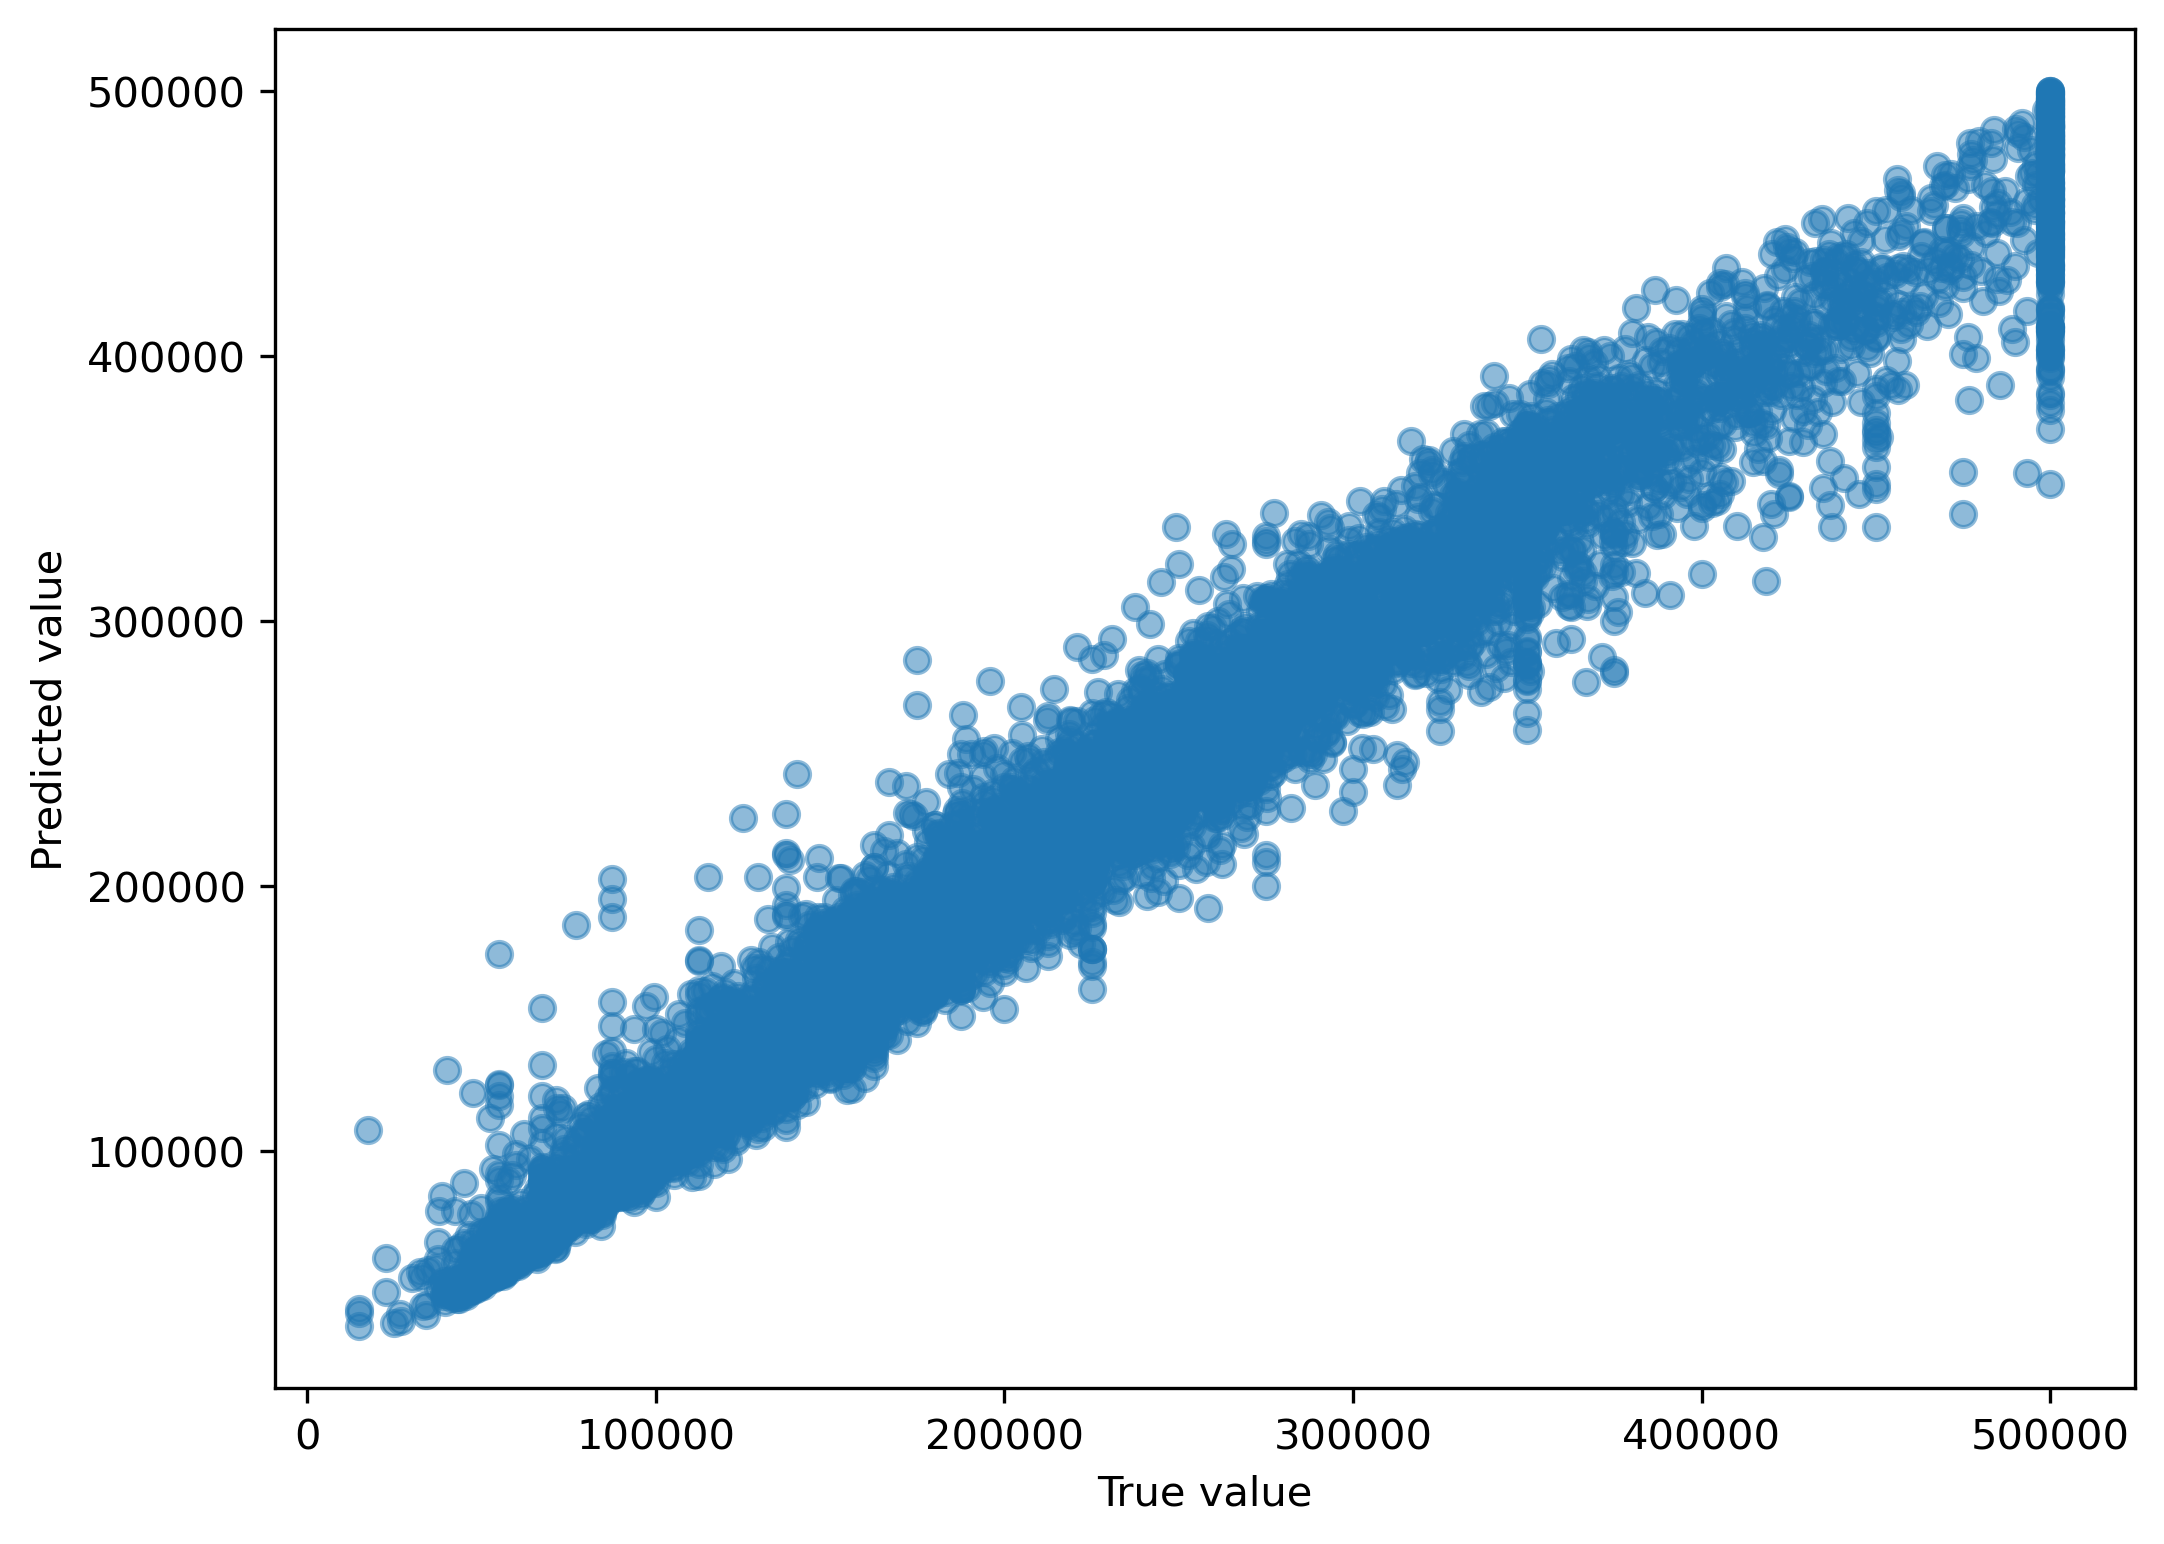

In [113]:
evaluate_base_model(X_train, y_train, X_test, y_test)

For the **pure** Random Forest model, the RMSE of training data is much lower than that of testing data, which indicates overfitting. 

Tuned Random Forest
train RMSE: 57911.545


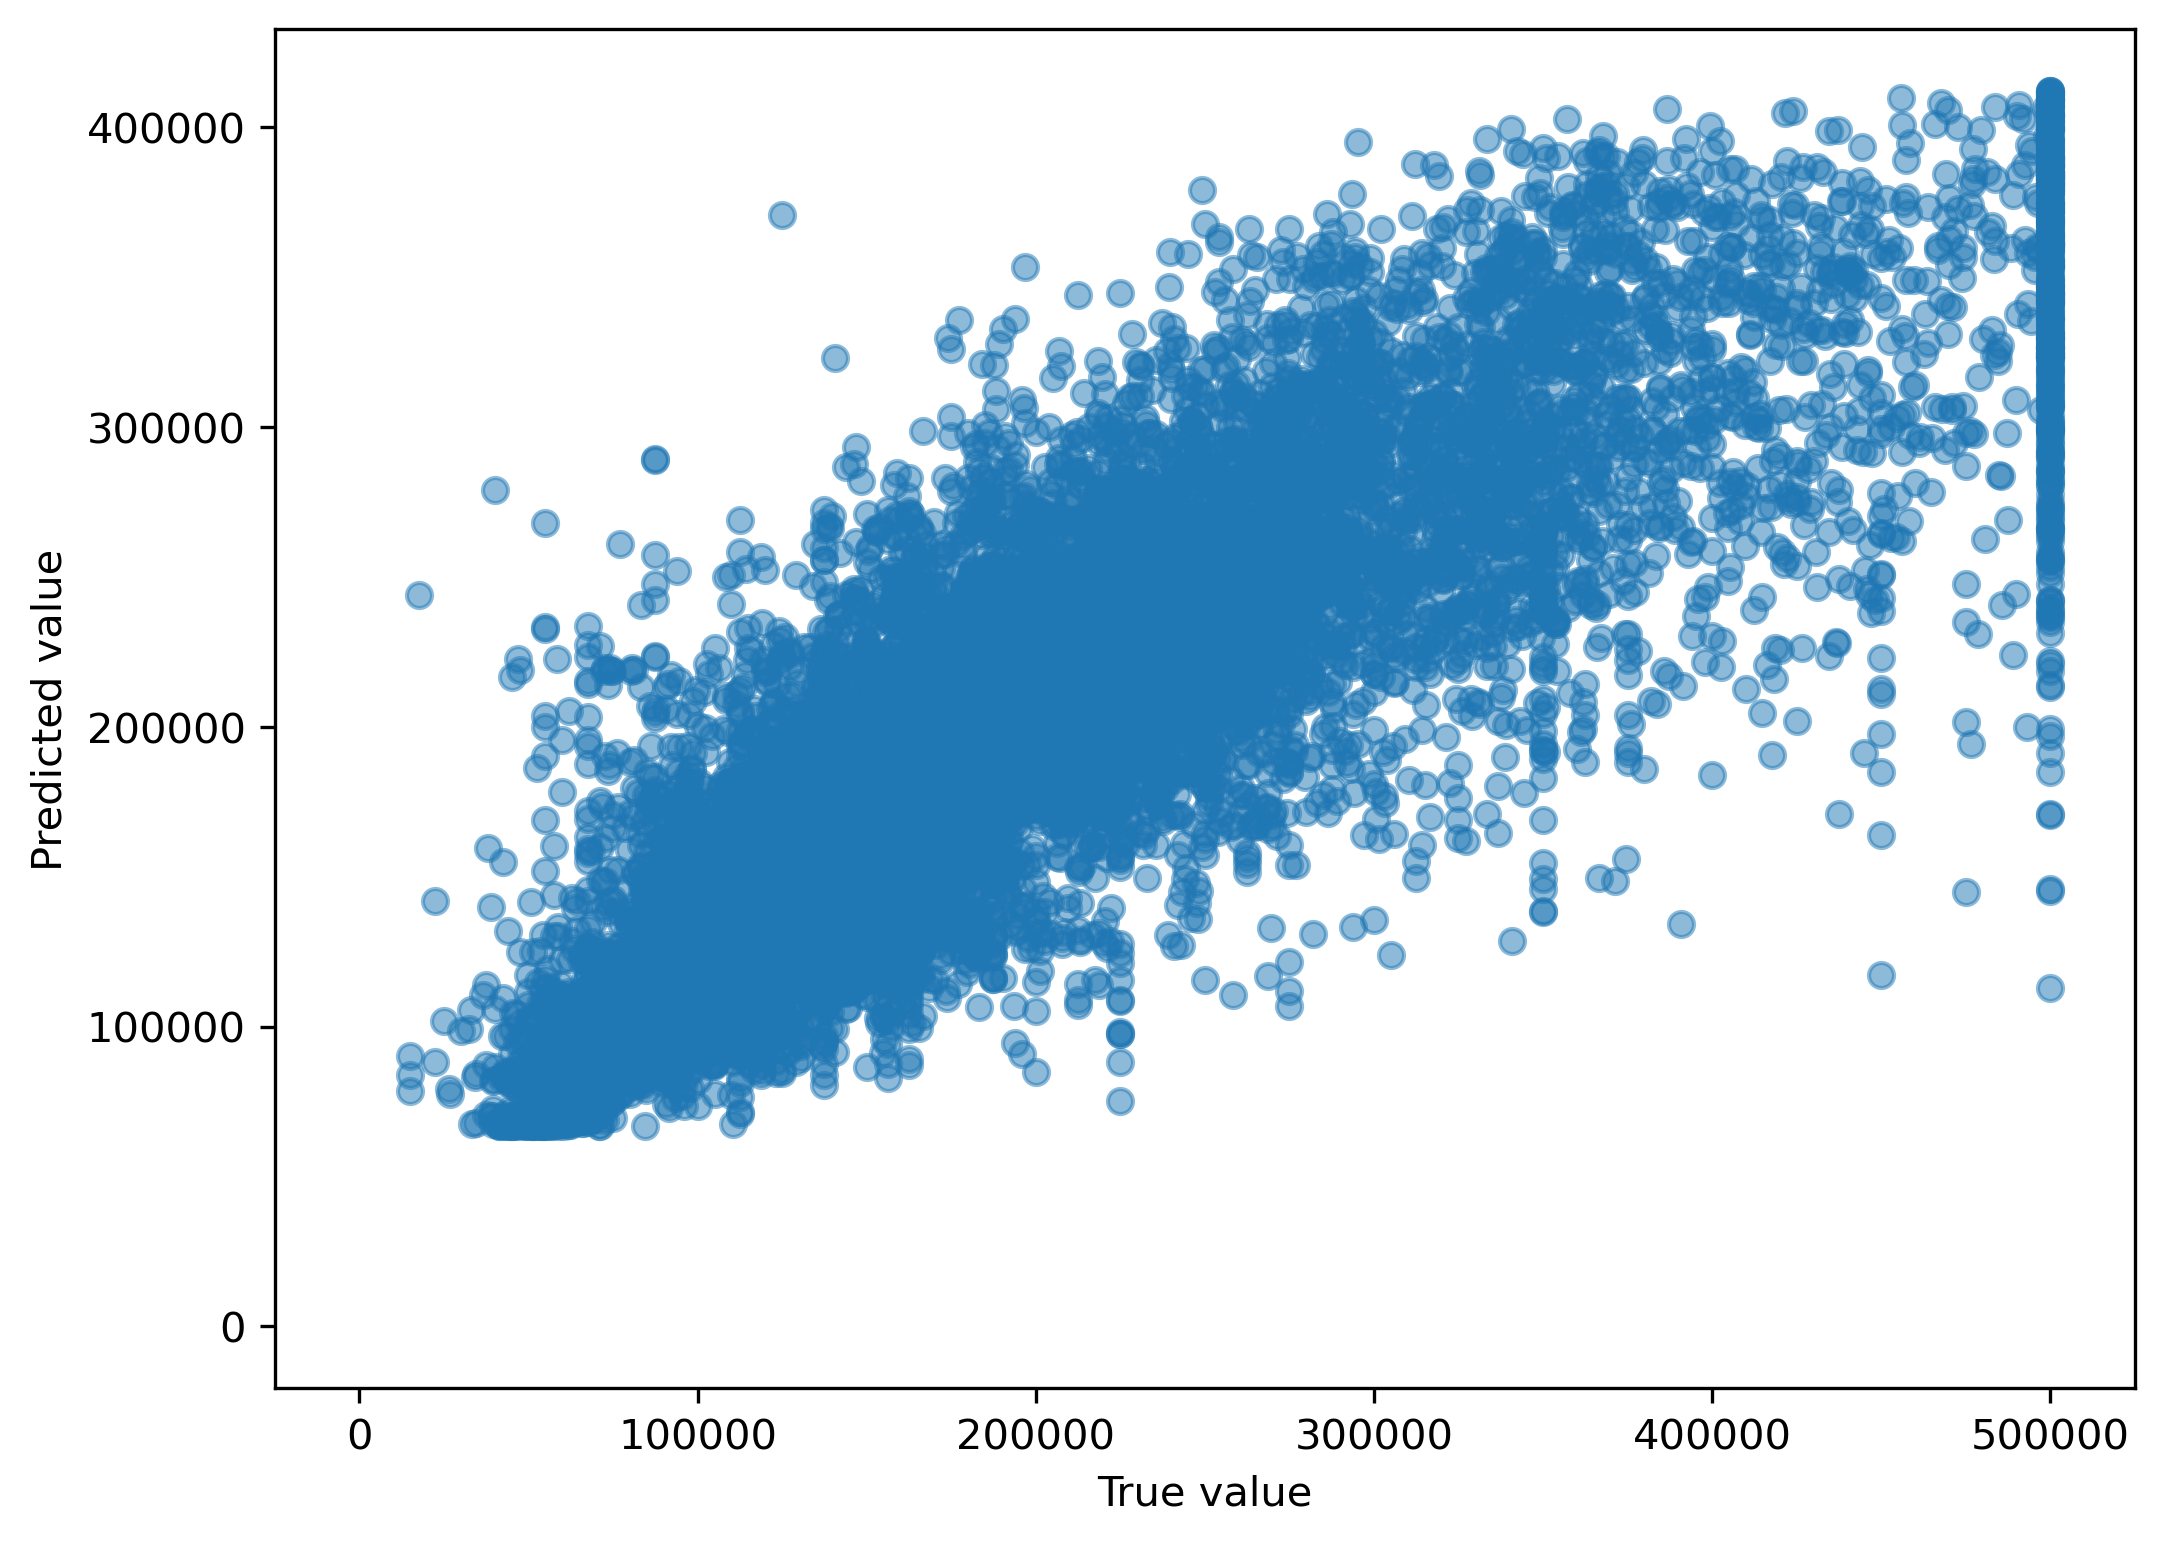

test RMSE: 59018.085


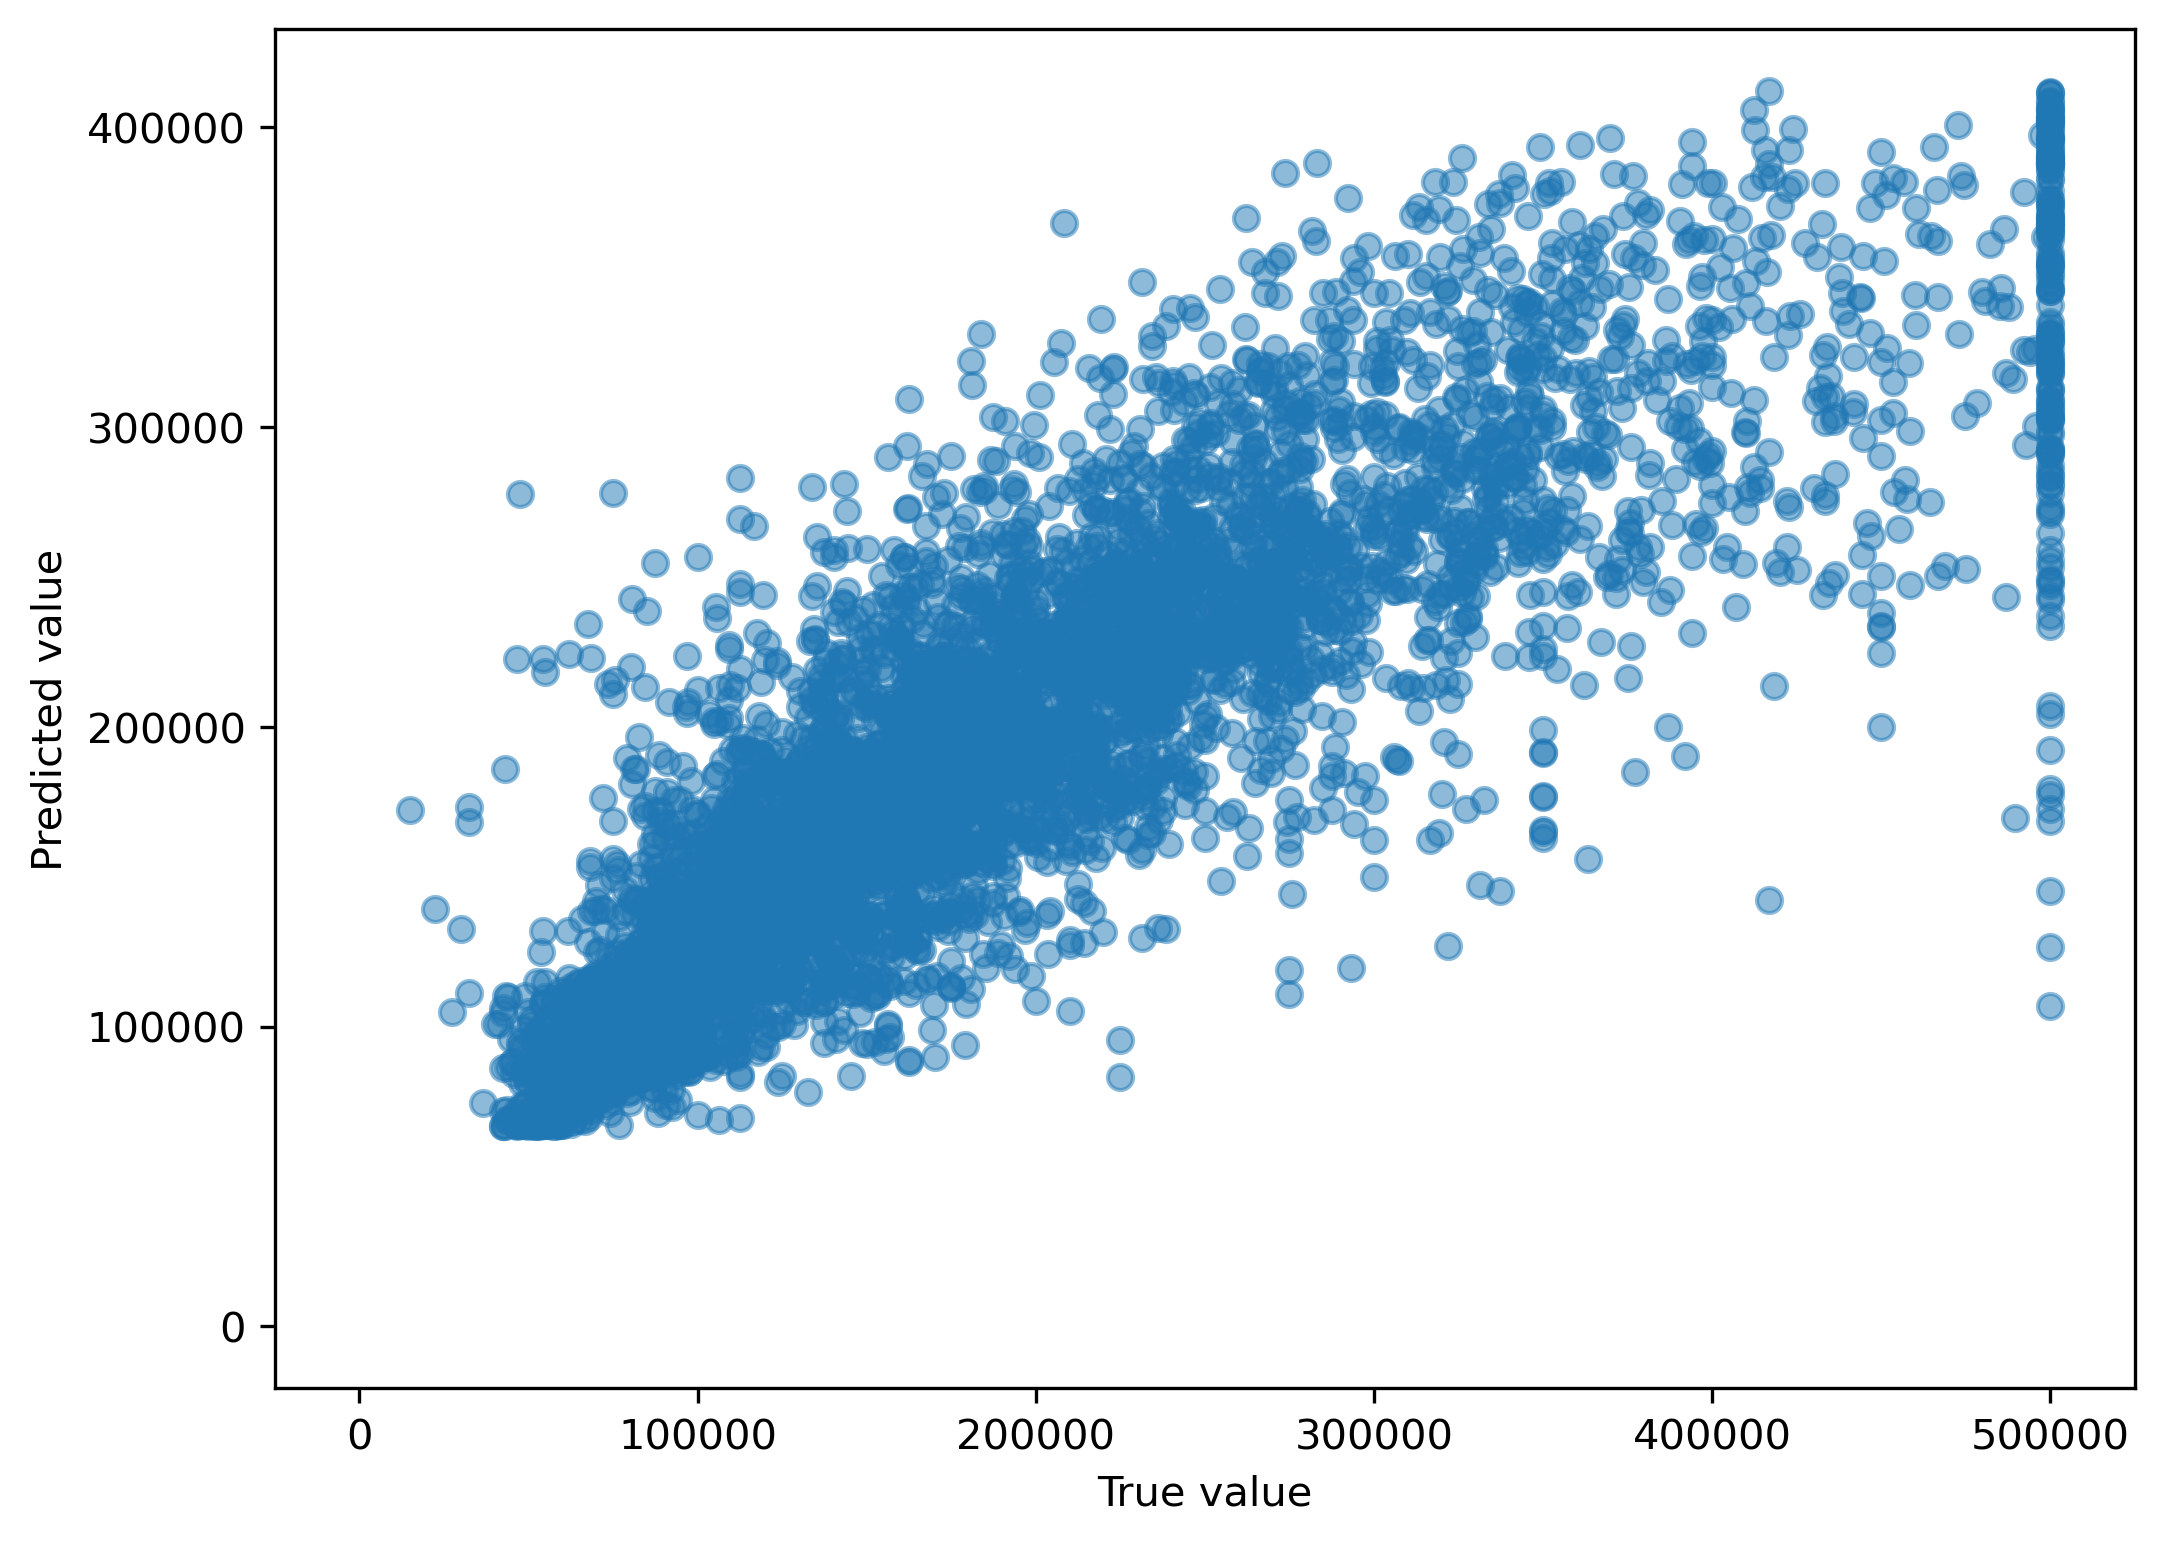

In [107]:
evaluate_tuned_model(X_train, y_train, X_test, y_test)

For the **tuned** Random Forest model, the RMSEs of training data and testing data are close to each other.